In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import math
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, wait
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )\
        .query("race != 'Asian'")\
        .query("race != 'Native American'")\
        .query("race != 'Other'")\
        .query("race != 'Hispanic'")

print(full_data.shape)

# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text', 'id']
full_data = full_data.loc[:, columns_kept]

full_data = full_data.set_index('id')

full_data.head()

(7214, 53)
(5278, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text
id,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,African-American,1,0,Low
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,Caucasian,1,0,Low
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,African-American,1,0,Medium
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,2014-03-15 05:35:34,2014-03-18 04:28:46,Caucasian,0,1,Low
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,2013-11-25 06:31:06,2013-11-26 08:26:57,Caucasian,1,0,Low


In [3]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,age_cat_Less than 25,sex_Female,sex_Male,race_African_American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,0,1,1,0,1,0,Low,1,0
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,0,1,1,0,1,0,Low,1,0
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,0,0,1,0,1,1,0,MediumHigh,0,1
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,0,1,0,0,1,0,1,Low,1,0
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,0,0,1,0,1,1,0,Low,1,0


In [4]:
X_Labels = ['sex_Male', 'age', 'race_African_American', 'priors_count',\
            'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    #"tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)


[0]	test-auc:0.79766
[1000]	test-auc:0.83840
[2000]	test-auc:0.83959
[3000]	test-auc:0.83853
[4000]	test-auc:0.83652
[5000]	test-auc:0.83459
[6000]	test-auc:0.83343
[7000]	test-auc:0.83205
[8000]	test-auc:0.83071
[9000]	test-auc:0.82942
[9999]	test-auc:0.82832


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show()

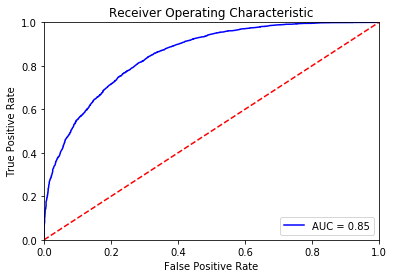

Optimal Threshold obtained using difference of TPR and FPR 0.52009827


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [7]:
def d(indiv, other, cat, con, madArray, pred_func, columns=X_Labels):    
    dfm = pd.DataFrame([indiv, other], columns=columns)    
    preds = pred_func(xgboost.DMatrix(dfm))
    
    if preds.round().sum() != 1:
        return -1,
    
    ncat = len(cat)
    ncon = len(con)
            
    # MAD normalized L1 Norm
    normedl1norm = 0
    for index in con:
        mad = madArray[index]
        normedl1norm += abs(indiv[index] - other[index]) / mad

        
    # simpMat
    # both pos
    npindiv = np.array(indiv).astype(int)[cat]
    npother = np.array(other).astype(int)[cat]
        
    PosMat = npindiv & npother 
    NegMat = (1 - npindiv) & (1 - npother)
    total = npother.shape[0]
    dist = 1-((PosMat.sum() + NegMat.sum())/total)
        
    n = ncat + ncon
    return (1/(ncon*normedl1norm/n + ncat*dist/n),)

In [8]:
b = {
    'sex_Male':   ("catagorical", 2),
    'age':        ("continous", 100),
    'race_African_American': ("catagorical", 2),
    'priors_count':   ("continous", 100),
    'juv_fel_count':  ("continous", 100),
    'c_charge_degree_F': ("catagorical", 2),
    'c_charge_degree_M': ("catagorical", 2)
}
ordered_cols = X_Labels

madArr = [0] * len(ordered_cols)
for feature in ordered_cols:
    bounds = b[feature]
    if bounds[0].startswith("cont"):
        madArr[ordered_cols.index(feature)] = learning_data.loc[:, feature].mad()


cat_list = []
con_list = []

for feature in ordered_cols:
    if b[feature][0].startswith('cata'):
        cat_list.append(ordered_cols.index(feature))
    else:
        con_list.append(ordered_cols.index(feature))

def create_bound_func_arr():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var
    for i in con_list:
        ret[i] = toolbox.con_var
    return ret

def create_indiv():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var()
    for i in con_list:
        ret[i] = toolbox.con_var()
    return creator.Individual(ret)

def mutate(indiv, func_arr, prob_mut):
    for i in range(len(indiv)):
        if(random.random() <= prob_mut):
            indiv[i] = func_arr[i]()
    return indiv,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("cata_2_var", random.randint, 0, 1)
toolbox.register("con_var", random.uniform, 0, 100)

toolbox.register("individual", create_indiv)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, func_arr=create_bound_func_arr(), prob_mut=.5)
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
c_facts_df = pd.read_csv("compas_cfact_10_29_2020_09_53.csv")    
c_facts_df.index = c_facts_df.id
c_facts_df.head()

,id,sex_Male,age,race_African_American,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,fitness
id,,,,,,,,,
3,3,1,33.404654,1,4.332325,0.170087,1,0,0.849307
4,4,1,37.692964,1,4.283286,0.103374,0,0,0.860210
8,8,1,45.575037,0,14.181760,0.020058,1,0,3.344617
10,10,0,27.331523,0,0.940279,0.013567,0,1,1.459273
14,14,0,25.997955,0,0.769521,0.158297,1,0,1.168439


In [10]:
burden_data = learning_data.copy()
burden_data = burden_data.loc[:,X_Labels]

c_facts = []

pop_size = len(X_Labels)**2
gens = 40

In [9]:
for i in range(burden_data.shape[0]):
    
    iper = burden_data.iloc[i].values.tolist()
    toolbox.register("evaluate", d, other=iper, cat=cat_list, con=con_list, madArray=madArr, pred_func=model.predict)

    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=gens, halloffame=hof, verbose=False)

    print(str(i), ": Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    cfact_final = list(hof[0])
    cfact_final.append(hof[0].fitness.values[0])
        
    c_facts.append(cfact_final)
        
    toolbox.unregister("evaluate")

c_facts_df = pd.DataFrame(c_facts, columns=X_Labels+['fitness'], 
                          index=burden_data.index)
print(c_facts_df.shape)
c_facts_df.head()

0 : Best individual is: [1, 26.94300639336137, 1, 2.1066016881319594, 0.4592928170590649, 1, 0]
with fitness: (0.44681295951402156,)
1 : Best individual is: [1, 35.60548509525123, 0, 4.302807662517427, 3.4741665640372843, 1, 0]
with fitness: (0.07529984306714364,)
2 : Best individual is: [1, 91.64994624386826, 0, 3.6616652608530864, 0.5081639533613846, 1, 1]
with fitness: (0.18125450815290045,)
3 : Best individual is: [0, 39.25941258000098, 0, 4.343131074381801, 0.5183205945959335, 0, 1]
with fitness: (0.41236655894514507,)
4 : Best individual is: [1, 28.298314552473446, 0, 3.898452996488, 1.0284944372589977, 1, 0]
with fitness: (0.23451169690931284,)
5 : Best individual is: [1, 23.73319451639485, 0, 1.460539535495431, 1.3983024802425859, 0, 1]
with fitness: (0.18416276705253834,)
6 : Best individual is: [1, 33.771409238286644, 1, 0.823130911582659, 1.3293687397875842, 0, 1]
with fitness: (0.1870575335920871,)
7 : Best individual is: [1, 37.342638169741235, 1, 6.924608856361014, 0.1490

62 : Best individual is: [1, 52.61639969309139, 0, 7.559807331044488, 0.558128314694295, 1, 0]
with fitness: (0.3243945567278087,)
63 : Best individual is: [1, 38.33024980331289, 0, 6.643002767858985, 4.0689810146509515, 1, 0]
with fitness: (0.06522868789085515,)
64 : Best individual is: [1, 48.936074362266815, 0, 7.146527666356728, 0.9872268293548259, 1, 0]
with fitness: (0.2052894332641125,)
65 : Best individual is: [0, 36.66663660618564, 0, 1.8612916194637674, 1.24839281430158, 1, 0]
with fitness: (0.18201537159901857,)
66 : Best individual is: [0, 40.034896333319594, 1, 4.70251433666723, 0.02750077744931856, 1, 0]
with fitness: (1.3070249381206471,)
67 : Best individual is: [1, 52.437525438604204, 1, 2.5307795118883147, 1.8880985466898648, 0, 1]
with fitness: (0.13322440559221682,)
68 : Best individual is: [1, 19.65066317939921, 1, 1.765536268057466, 0.04160769889657301, 0, 1]
with fitness: (3.6468642903760253,)
69 : Best individual is: [1, 29.45033817174648, 1, 5.482794472688079, 

124 : Best individual is: [1, 34.99434869649465, 0, 6.382923668733797, 3.082445552962254, 0, 1]
with fitness: (0.0857200489499994,)
125 : Best individual is: [1, 78.23235523560342, 1, 10.522478352821018, 0.2086945943903018, 0, 1]
with fitness: (0.4796804110730862,)
126 : Best individual is: [0, 24.326078731403143, 0, 0.8415376549005482, 0.6482820658693433, 1, 0]
with fitness: (0.24960278332338806,)
127 : Best individual is: [1, 27.88116775317896, 0, 1.2598189903949009, 3.8408885385738722, 1, 0]
with fitness: (0.06969610277420717,)
128 : Best individual is: [1, 56.575063721470556, 0, 15.265545618584763, 0.8164034589171587, 0, 1]
with fitness: (0.22314634336819203,)
129 : Best individual is: [1, 21.28964211831388, 1, 0.13936077260616742, 0.4189223612488746, 0, 1]
with fitness: (0.6208521423270064,)
130 : Best individual is: [1, 66.87246791146056, 1, 12.666531040146767, 0.3755845080159248, 1, 0]
with fitness: (0.3857100632600736,)
131 : Best individual is: [0, 44.7904007656595, 0, 9.94759

186 : Best individual is: [0, 48.14088907528401, 1, 4.110084063407471, 1.3143676304020135, 1, 0]
with fitness: (0.18382974430930887,)
187 : Best individual is: [1, 22.56748561855757, 0, 0.5912650199142555, 5.093146476806787, 1, 0]
with fitness: (0.053122599250269374,)
188 : Best individual is: [0, 49.253884914221935, 1, 4.144214876230734, 0.52848968866962, 1, 0]
with fitness: (0.4029624043464714,)
189 : Best individual is: [1, 20.836123164682885, 0, 7.701444618010489, 0.04453312146230903, 1, 0]
with fitness: (0.7705952988203137,)
190 : Best individual is: [1, 27.504333220494782, 1, 1.1731379292380328, 0.7766044012358586, 1, 0]
with fitness: (0.3202169841378727,)
191 : Best individual is: [1, 27.10245899535585, 0, 2.9887269931608396, 0.600290239511514, 0, 1]
with fitness: (0.2687502107304967,)
192 : Best individual is: [1, 46.53285262169099, 0, 1.9138983249914476, 2.310986397828585, 1, 1]
with fitness: (0.10118238111562038,)
193 : Best individual is: [1, 16.33515764369117, 0, 0.34843107

247 : Best individual is: [1, 27.24993363121794, 1, 5.383151518430229, 0.0874771417216591, 0, 1]
with fitness: (1.2307522511254487,)
248 : Best individual is: [0, 42.11550561519357, 1, 2.9163991017019497, 1.1757429292028831, 0, 1]
with fitness: (0.17991054900230996,)
249 : Best individual is: [1, 12.477264217641281, 0, 0.015752955029391114, 1.9750614942681821, 1, 0]
with fitness: (0.9340548584270965,)
250 : Best individual is: [1, 31.71303359068247, 0, 3.4400287729169365, 1.180292999586241, 1, 0]
with fitness: (0.20938679228166987,)
251 : Best individual is: [1, 27.302738744720333, 1, 0.6783501807880676, 0.1396147899777711, 1, 0]
with fitness: (1.2102543228595857,)
252 : Best individual is: [1, 33.762769119102764, 0, 2.7189601015327303, 0.07922170964433928, 0, 1]
with fitness: (1.1111872737922817,)
253 : Best individual is: [1, 41.81446152345971, 0, 6.347222412916831, 2.2196073265141947, 1, 0]
with fitness: (0.1063908383969756,)
254 : Best individual is: [1, 27.114167178732195, 1, 0.44

308 : Best individual is: [1, 33.23376185799015, 1, 3.83931822080662, 0.35677961410056636, 0, 1]
with fitness: (0.5146148127342668,)
309 : Best individual is: [1, 19.358511208432493, 0, 1.3275742632630982, 0.7778927659103374, 1, 0]
with fitness: (0.9839425672513918,)
310 : Best individual is: [1, 28.30938730924588, 1, 0.20042086015663596, 0.02389024557654107, 0, 1]
with fitness: (2.6503701760187623,)
311 : Best individual is: [1, 48.86561895238849, 1, 2.232791929395994, 0.8539823707285898, 1, 0]
with fitness: (0.25032486947626353,)
312 : Best individual is: [0, 42.57841836228432, 1, 3.9100190814692737, 0.083872926404982, 1, 0]
with fitness: (1.3388810967481266,)
313 : Best individual is: [1, 29.94819270326493, 1, 8.01496536814822, 0.2899634121504624, 0, 1]
with fitness: (0.5212197092670524,)
314 : Best individual is: [1, 38.406867317254786, 1, 5.724720459111843, 0.6123665425356362, 1, 0]
with fitness: (0.43001847599553317,)
315 : Best individual is: [1, 23.304696757366084, 0, 2.7330391

370 : Best individual is: [1, 18.26794747291015, 0, 3.1103016932180982, 0.20038091983212158, 0, 1]
with fitness: (0.7572068505314574,)
371 : Best individual is: [1, 47.78122291709839, 0, 3.5769788683716275, 0.9241109880313791, 1, 0]
with fitness: (0.218708873777257,)
372 : Best individual is: [1, 25.2545751396812, 1, 1.8251050514145328, 0.46525327620212664, 0, 1]
with fitness: (0.5560894427322502,)
373 : Best individual is: [1, 21.4904600488775, 1, 1.0903131098264907, 1.7734325500571968, 0, 1]
with fitness: (0.1376049374159189,)
374 : Best individual is: [1, 36.89013739253594, 1, 6.483704104224197, 0.10740593388434139, 1, 0]
with fitness: (1.0218181347699566,)
375 : Best individual is: [1, 31.479565941966104, 1, 1.1481842459240443, 1.0134899205700876, 1, 0]
with fitness: (0.2594025989787923,)
376 : Best individual is: [1, 32.26320217019274, 0, 0.6375881142164919, 3.06924289389251, 1, 0]
with fitness: (0.08549269925193488,)
377 : Best individual is: [1, 24.447215631079168, 0, 2.42617593

431 : Best individual is: [1, 37.58889795749477, 1, 3.7122562085005417, 0.05623163075358928, 1, 0]
with fitness: (1.24960401688705,)
432 : Best individual is: [1, 49.46088583228775, 0, 7.924178129440806, 1.1356997148792125, 0, 1]
with fitness: (0.19379058078491215,)
433 : Best individual is: [1, 27.4108731440484, 1, 4.169705885956421, 0.0787704414825563, 0, 1]
with fitness: (1.3040393495260185,)
434 : Best individual is: [1, 49.82752907635653, 0, 12.219583692416547, 0.601039221427635, 1, 0]
with fitness: (0.28038240907745127,)
435 : Best individual is: [0, 58.27132257228593, 0, 7.41014974390779, 2.062366068630206, 0, 1]
with fitness: (0.12349814036410264,)
436 : Best individual is: [0, 33.133953632699644, 0, 3.1406307210137485, 0.20955709823334834, 0, 0]
with fitness: (0.7294744708259417,)
437 : Best individual is: [0, 13.935217592565085, 1, 0.14425927527862425, 0.26850681570750323, 0, 1]
with fitness: (0.7408914650470296,)
438 : Best individual is: [1, 43.70994090160186, 0, 1.49081539

492 : Best individual is: [1, 25.523834561141012, 1, 0.42622726057751636, 0.23562024273173776, 0, 1]
with fitness: (1.0079378796424059,)
493 : Best individual is: [1, 38.01590246153796, 1, 9.23956990100282, 0.3643230086849858, 1, 0]
with fitness: (0.38410168822711765,)
494 : Best individual is: [1, 42.10261263990708, 1, 15.774611451037668, 0.8657089346519431, 1, 0]
with fitness: (0.19023399046851397,)
495 : Best individual is: [1, 44.1362768667927, 1, 5.7338130095858535, 0.10584171990044577, 1, 0]
with fitness: (1.3619244579377539,)
496 : Best individual is: [1, 53.16526623113682, 0, 8.721246501604284, 3.3235284900213657, 0, 1]
with fitness: (0.07380822395309172,)
497 : Best individual is: [1, 40.64258471031248, 0, 11.171319446388129, 3.1333078402646652, 0, 0]
with fitness: (0.08073246320034524,)
498 : Best individual is: [1, 34.05073043227069, 0, 8.352254660149228, 0.19151828239220015, 1, 0]
with fitness: (0.535759057442939,)
499 : Best individual is: [0, 55.97270943008894, 1, 7.75832

553 : Best individual is: [1, 34.95071399862791, 1, 4.199024574898102, 1.6918549342836986, 1, 0]
with fitness: (0.16016717357066937,)
554 : Best individual is: [0, 49.946205241537, 1, 7.272027004880444, 1.8484347380711474, 1, 0]
with fitness: (0.12878679336283808,)
555 : Best individual is: [1, 24.777440736850163, 0, 7.647367572726404, 0.008325325900793157, 1, 0]
with fitness: (0.8538188214598532,)
556 : Best individual is: [1, 26.24619254671565, 0, 0.47241451095876297, 0.8266350706278458, 1, 0]
with fitness: (0.29271221732522584,)
557 : Best individual is: [1, 22.472902406225238, 0, 0.5930658462226623, 1.1622424713525814, 1, 0]
with fitness: (0.23235741912731017,)
558 : Best individual is: [1, 64.65753197604307, 1, 7.970116050549658, 0.05824284894647702, 1, 0]
with fitness: (1.0795612391344525,)
559 : Best individual is: [1, 47.19650139074233, 0, 8.813875600782639, 0.25795717895615855, 1, 0]
with fitness: (0.4858487354395775,)
560 : Best individual is: [0, 37.756031221990895, 1, 2.696

614 : Best individual is: [1, 41.766588429269135, 0, 9.563790608837241, 0.1894000829477327, 1, 0]
with fitness: (0.486522180496076,)
615 : Best individual is: [1, 34.01912290245899, 0, 5.111426503528438, 5.550453621652318, 0, 0]
with fitness: (0.04746515630255388,)
616 : Best individual is: [0, 24.81077934819388, 0, 0.8925728435004943, 0.1915671107024286, 0, 1]
with fitness: (1.0268439001460654,)
617 : Best individual is: [1, 30.071783143744536, 1, 1.5339508230736043, 0.44896088994665906, 1, 0]
with fitness: (0.5095328686183955,)
618 : Best individual is: [1, 49.690715209578585, 0, 8.619506280688993, 3.2281385097303605, 0, 1]
with fitness: (0.08005314928070333,)
619 : Best individual is: [1, 35.4978098264221, 0, 4.910580173410839, 2.7228450688184247, 1, 0]
with fitness: (0.09746071869846154,)
620 : Best individual is: [1, 15.92699386590607, 0, 1.0129934936135343, 0.2444832001713082, 1, 0]
with fitness: (0.7688777290246683,)
621 : Best individual is: [0, 48.62396496014105, 1, 11.0204750

676 : Best individual is: [1, 17.388538332686853, 0, 6.054704158151547, 0.2532107134271988, 1, 0]
with fitness: (0.561485324496243,)
677 : Best individual is: [1, 26.642874022518082, 1, 1.7499013194743562, 0.17687946527552567, 1, 1]
with fitness: (0.9749571164382329,)
678 : Best individual is: [1, 43.66626872179696, 1, 10.379730807388754, 0.4960877088404869, 1, 0]
with fitness: (0.3187077704319716,)
679 : Best individual is: [1, 38.66593649053887, 1, 5.030559420114633, 0.20799668543356464, 1, 0]
with fitness: (0.8006433388127031,)
680 : Best individual is: [0, 35.894060022355355, 0, 4.038695756346233, 0.16579269822732945, 1, 0]
with fitness: (0.9663021041887251,)
681 : Best individual is: [1, 42.44849159767726, 0, 14.060164575845347, 0.2795727336324938, 1, 0]
with fitness: (0.4554367330484269,)
682 : Best individual is: [1, 23.72372955172605, 0, 3.1827352652527785, 1.2430535941235221, 0, 1]
with fitness: (0.20295092341995474,)
683 : Best individual is: [1, 25.08936016339762, 0, 1.10670

737 : Best individual is: [1, 33.458712295354665, 1, 8.406997549860584, 1.1402441656271134, 0, 1]
with fitness: (0.19558319349770636,)
738 : Best individual is: [1, 42.68457082803165, 1, 2.333458518691811, 1.2551486963110259, 0, 1]
with fitness: (0.20626826138920246,)
739 : Best individual is: [0, 46.81601215132076, 0, 5.970972607580083, 0.06412263943023078, 0, 1]
with fitness: (0.8031905667987193,)
740 : Best individual is: [1, 37.21275402812616, 0, 3.8740090289489992, 1.6647186323659802, 0, 1]
with fitness: (0.13305177717592048,)
741 : Best individual is: [1, 52.41183513470429, 0, 13.611986562861844, 2.6323991139199143, 1, 0]
with fitness: (0.09793804836009994,)
742 : Best individual is: [1, 27.753927462219007, 1, 4.574153338422738, 0.18641708350859432, 1, 0]
with fitness: (0.8695369040522644,)
743 : Best individual is: [1, 34.707002681176824, 0, 7.952191776266182, 0.1833299315094239, 1, 0]
with fitness: (0.49394153172331523,)
744 : Best individual is: [0, 35.150746872059315, 0, 5.15

799 : Best individual is: [1, 32.56207299810687, 0, 5.000073330391941, 0.8264760993775488, 0, 1]
with fitness: (0.2625744600840686,)
800 : Best individual is: [0, 32.316581447438644, 0, 3.743188910383577, 0.3518629098718473, 0, 1]
with fitness: (0.4810105373587991,)
801 : Best individual is: [1, 52.66122044852673, 0, 8.693968051621093, 0.206373309750163, 1, 0]
with fitness: (0.7360136451832306,)
802 : Best individual is: [1, 35.28262950529507, 1, 4.063461977570693, 0.26973633106606165, 0, 0]
with fitness: (0.8012740499579885,)
803 : Best individual is: [1, 34.7940950722373, 0, 6.368859932693615, 2.569598027577713, 1, 0]
with fitness: (0.09562315276046142,)
804 : Best individual is: [1, 92.82040440223359, 1, 13.165229713012971, 0.5381020858838514, 1, 0]
with fitness: (0.20537998815013947,)
805 : Best individual is: [0, 52.34326512044427, 1, 7.883786688157535, 0.0014257039242515646, 1, 0]
with fitness: (1.1489718699165603,)
806 : Best individual is: [1, 42.286926957090174, 1, 4.861109865

861 : Best individual is: [1, 35.900574388479335, 1, 1.3574704353672584, 0.5326355588011755, 0, 1]
with fitness: (0.4838386033263131,)
862 : Best individual is: [1, 38.468175594569296, 0, 8.391656252113567, 0.6354382872259201, 1, 0]
with fitness: (0.2900668015207181,)
863 : Best individual is: [1, 20.073401159757786, 1, 1.879812156055305, 0.06958758443249558, 0, 1]
with fitness: (1.6272047258456594,)
864 : Best individual is: [1, 46.48693684222409, 1, 3.995991474070759, 0.8694110914281072, 0, 0]
with fitness: (0.25311524323916973,)
865 : Best individual is: [1, 29.830748597657355, 0, 0.8342680728348317, 2.0229832282602445, 1, 0]
with fitness: (0.12483066149390079,)
866 : Best individual is: [1, 25.387062063984402, 0, 1.1211178796623478, 0.875324966279456, 1, 0]
with fitness: (0.2791946449725446,)
867 : Best individual is: [1, 37.809478036801416, 1, 6.009232500171646, 0.20722986873122906, 0, 1]
with fitness: (0.6181738040064502,)
868 : Best individual is: [0, 16.05624615692888, 0, 1.614

923 : Best individual is: [1, 31.84796574334031, 0, 4.417783828023747, 1.9534123144796411, 0, 1]
with fitness: (0.13743636598205947,)
924 : Best individual is: [1, 21.750371076660713, 1, 0.7851850243959735, 0.15302602932855125, 0, 1]
with fitness: (1.1297665163650215,)
925 : Best individual is: [1, 22.735626876046645, 0, 2.8596609113074822, 0.31776120458039125, 0, 1]
with fitness: (0.5471390179990293,)
926 : Best individual is: [0, 50.977949766700384, 0, 4.920532190376681, 2.065130379879654, 1, 0]
with fitness: (0.13350606242222582,)
927 : Best individual is: [1, 36.43891383218071, 0, 3.3228719221729763, 3.845870238269833, 1, 0]
with fitness: (0.06860530536994597,)
928 : Best individual is: [1, 30.802249383499415, 1, 0.7866651158444093, 2.0924763200784624, 1, 0]
with fitness: (0.12938202492741827,)
929 : Best individual is: [1, 42.70436359124773, 1, 3.939153468535417, 0.40671444858770833, 0, 0]
with fitness: (0.535193079396243,)
930 : Best individual is: [1, 38.85858145216905, 1, 3.386

985 : Best individual is: [1, 49.03271905860868, 0, 16.874311398196863, 0.46191897793005365, 0, 0]
with fitness: (0.3458865658986016,)
986 : Best individual is: [1, 24.45023817199824, 1, 9.909966768948031, 0.5055052299008933, 0, 0]
with fitness: (0.20411162446316103,)
987 : Best individual is: [1, 37.44690424495373, 0, 7.114712184836147, 1.788129668092775, 1, 0]
with fitness: (0.13560114983255203,)
988 : Best individual is: [0, 25.73548096584689, 0, 5.596478989783737, 0.36614943267059274, 1, 0]
with fitness: (0.47214422852685206,)
989 : Best individual is: [0, 22.910175202537108, 1, 0.8338787774729406, 0.11053545332788683, 1, 0]
with fitness: (0.9933463835767229,)
990 : Best individual is: [0, 57.80307953383008, 0, 9.127872330478127, 0.7285192776763205, 0, 1]
with fitness: (0.21972035630004277,)
991 : Best individual is: [1, 33.53949379645642, 1, 8.299185466475844, 0.15341385050192669, 1, 0]
with fitness: (0.6233219009641228,)
992 : Best individual is: [1, 40.91673891167616, 1, 2.57148

1046 : Best individual is: [0, 33.01582667838916, 0, 0.07123212111900257, 2.0347556172000902, 1, 1]
with fitness: (0.21068975604453222,)
1047 : Best individual is: [0, 30.066707911253822, 1, 1.1627098213167097, 2.103038749892272, 1, 0]
with fitness: (0.12575705302084275,)
1048 : Best individual is: [1, 34.83801285959949, 0, 2.7696420784643294, 1.3795063539624786, 1, 0]
with fitness: (0.30836084212527365,)
1049 : Best individual is: [1, 62.28167926214505, 0, 17.6541028241589, 0.3038962561400016, 1, 0]
with fitness: (0.2978997504268691,)
1050 : Best individual is: [0, 80.20086800569321, 0, 2.39197358021368, 0.14376844028944902, 0, 0]
with fitness: (0.27798100071316295,)
1051 : Best individual is: [1, 21.962013430374185, 0, 1.5730257621223487, 0.058972108644617105, 0, 1]
with fitness: (0.5913984327861183,)
1052 : Best individual is: [0, 24.353208866251443, 1, 2.221829753001292, 0.3738997779969, 1, 0]
with fitness: (0.37763207958114775,)
1053 : Best individual is: [1, 22.95700350109139, 1,

1107 : Best individual is: [0, 73.86463930571385, 0, 2.480278973274763, 0.4570399402181513, 0, 0]
with fitness: (0.22722179984640356,)
1108 : Best individual is: [1, 31.06325026116198, 1, 1.7280911725759518, 0.9377291981600422, 0, 1]
with fitness: (0.2669406944373777,)
1109 : Best individual is: [1, 25.89398217110159, 0, 1.0009915150716364, 1.6171169179276523, 1, 0]
with fitness: (0.1613271252740424,)
1110 : Best individual is: [1, 32.378257067369965, 1, 2.7839184633719594, 0.9044867158763514, 0, 1]
with fitness: (0.2963110288095818,)
1111 : Best individual is: [1, 60.555376595300544, 0, 12.164389506713446, 4.999539684420462, 1, 0]
with fitness: (0.07918052857376201,)
1112 : Best individual is: [1, 49.82395777330226, 0, 10.146109989306474, 1.3397822047228947, 1, 0]
with fitness: (0.18049551274776757,)
1113 : Best individual is: [1, 22.87528436659413, 1, 1.6555986794494548, 0.5956772381458864, 1, 0]
with fitness: (0.41652087165402246,)
1114 : Best individual is: [1, 40.36706272974896, 1

1168 : Best individual is: [1, 34.062253966605695, 1, 4.549880530559413, 0.21470967663010931, 0, 1]
with fitness: (0.9062939716365649,)
1169 : Best individual is: [1, 28.396143520027362, 1, 0.6787050232327063, 1.7851487459051407, 0, 0]
with fitness: (0.14331528261537752,)
1170 : Best individual is: [1, 31.28584420533641, 0, 1.1089247656623558, 1.386565592840483, 1, 0]
with fitness: (0.13024539701117566,)
1171 : Best individual is: [1, 23.42286913436411, 0, 1.3402570844816664, 2.7946296394043113, 1, 1]
with fitness: (0.08396119795519144,)
1172 : Best individual is: [1, 39.77398786927079, 1, 1.4599446344662703, 1.4641217575761978, 1, 0]
with fitness: (0.12232569653468388,)
1173 : Best individual is: [1, 48.96681721508558, 1, 5.810690936809426, 2.0816358207637276, 1, 0]
with fitness: (0.5345286322172864,)
1174 : Best individual is: [1, 28.48439785165541, 1, 2.243742248064373, 0.17890557092494763, 1, 0]
with fitness: (0.9986237120666307,)
1175 : Best individual is: [1, 59.54891623497285, 0

1229 : Best individual is: [1, 51.23553529756314, 0, 13.505441359786385, 0.0027252335813909845, 1, 0]
with fitness: (0.38655644773962344,)
1230 : Best individual is: [1, 31.11323274808562, 0, 1.9795354339907867, 3.1108345980873753, 1, 0]
with fitness: (0.08533146556705228,)
1231 : Best individual is: [1, 38.44626181846523, 0, 5.60896902089616, 0.21224326281022998, 0, 1]
with fitness: (0.5943256557754891,)
1232 : Best individual is: [1, 30.8250128047308, 0, 4.550165817452434, 0.7914243314985026, 1, 0]
with fitness: (0.30188746686938706,)
1233 : Best individual is: [1, 38.13538700960029, 1, 4.7906591222867885, 0.3217266166857691, 1, 0]
with fitness: (0.6203230483350908,)
1234 : Best individual is: [1, 46.70783765471693, 1, 9.588279961047252, 0.48541662565390054, 1, 0]
with fitness: (0.3191664593288793,)
1235 : Best individual is: [1, 35.75720578159793, 0, 7.4813796557048455, 1.5451891394393624, 1, 0]
with fitness: (0.1626283422544612,)
1236 : Best individual is: [1, 56.18266493691231, 1,

1290 : Best individual is: [1, 49.13939736887212, 0, 7.739760654014615, 0.3586779556540076, 0, 1]
with fitness: (0.540119174581103,)
1291 : Best individual is: [1, 39.701330292242595, 1, 7.856008326977104, 0.2810967435517675, 1, 0]
with fitness: (0.713296475366889,)
1292 : Best individual is: [1, 35.612158979133405, 1, 6.0157149558292655, 0.2986353863022262, 0, 1]
with fitness: (0.35320072518986095,)
1293 : Best individual is: [1, 41.2049636579159, 0, 5.92539791171649, 0.8423464182513163, 1, 0]
with fitness: (0.2537415793880272,)
1294 : Best individual is: [0, 30.69914588342074, 0, 2.5111050472525154, 2.5855524947224984, 0, 1]
with fitness: (0.10322257162446635,)
1295 : Best individual is: [1, 22.830120640076913, 1, 5.558307289329322, 0.4020098554977425, 1, 0]
with fitness: (0.44663878824375525,)
1296 : Best individual is: [1, 93.37099255273901, 1, 7.385562018063863, 1.3203111927996725, 0, 1]
with fitness: (0.12769688329748224,)
1297 : Best individual is: [1, 31.778111587497527, 1, 1.3

1351 : Best individual is: [1, 45.74552084512062, 0, 7.136914960771012, 2.09459648774708, 1, 0]
with fitness: (0.5192071278751724,)
1352 : Best individual is: [0, 25.86987175558859, 1, 3.8777892884080956, 0.27616110835265717, 0, 1]
with fitness: (0.5907817298237376,)
1353 : Best individual is: [1, 31.921455942717746, 1, 3.3104477704924418, 0.08824629125819827, 1, 0]
with fitness: (0.8378152680729802,)
1354 : Best individual is: [1, 20.8687025072846, 0, 1.977155029510902, 0.08411157086836152, 0, 1]
with fitness: (1.0975291394152953,)
1355 : Best individual is: [0, 47.80567847602401, 0, 4.9965999721098715, 2.088587190975011, 1, 0]
with fitness: (0.12231044062500585,)
1356 : Best individual is: [1, 59.78560396188861, 0, 9.259530523972625, 1.6526753730455868, 1, 0]
with fitness: (0.1264608467425477,)
1357 : Best individual is: [1, 47.40705335993805, 0, 12.307422947364577, 0.28936080078262316, 1, 0]
with fitness: (0.5746468938667971,)
1358 : Best individual is: [1, 53.25759535916136, 0, 10.

1412 : Best individual is: [1, 44.79466783340226, 1, 2.5835415854791544, 1.0488939420865928, 0, 1]
with fitness: (0.21206426923201085,)
1413 : Best individual is: [1, 59.28190655575821, 1, 8.729482430760038, 0.34810403217756525, 1, 0]
with fitness: (0.5384341289545503,)
1414 : Best individual is: [0, 41.57777274235946, 1, 3.814995875783833, 0.021615617810177845, 1, 0]
with fitness: (1.7602232082377678,)
1415 : Best individual is: [1, 63.80963770014496, 0, 15.069246969956062, 1.7511761700259476, 0, 0]
with fitness: (0.11392037089301506,)
1416 : Best individual is: [1, 46.11769016565515, 1, 2.121494863344753, 0.6750551370428348, 1, 0]
with fitness: (0.36141537011875424,)
1417 : Best individual is: [1, 37.782525021411814, 0, 4.2317429175470656, 1.2189503412405434, 1, 0]
with fitness: (0.18469550152502243,)
1418 : Best individual is: [1, 27.881412980794572, 0, 3.58870742971813, 1.837137242430198, 0, 0]
with fitness: (0.13217426831066395,)
1419 : Best individual is: [1, 57.8652391935508, 1,

1473 : Best individual is: [0, 42.374792177614665, 0, 5.135221189129213, 0.20744628017523858, 0, 0]
with fitness: (0.5970755495754019,)
1474 : Best individual is: [1, 48.948022390625866, 1, 0.4772450574848319, 0.6035455054059669, 1, 0]
with fitness: (0.23833034430015615,)
1475 : Best individual is: [1, 33.58754337899563, 1, 4.739951347270043, 0.27414883869067985, 1, 0]
with fitness: (0.6984050439359171,)
1476 : Best individual is: [1, 39.04632018639182, 0, 6.64328893959688, 1.5482146274476194, 1, 0]
with fitness: (0.16749182971931437,)
1477 : Best individual is: [1, 31.6875150352394, 0, 4.533159434788791, 0.2890540540285924, 1, 0]
with fitness: (0.6170956396600071,)
1478 : Best individual is: [1, 50.258766422436096, 1, 8.802784717214928, 0.10091494793054157, 1, 0]
with fitness: (0.8639975617436196,)
1479 : Best individual is: [1, 24.654044793440598, 0, 3.988258322253846, 1.385633299864475, 1, 0]
with fitness: (0.18050408508823293,)
1480 : Best individual is: [1, 25.136044037798943, 1, 

1534 : Best individual is: [1, 38.9387714238542, 1, 2.086540688421523, 0.01531062568506103, 1, 0]
with fitness: (1.095385943891555,)
1535 : Best individual is: [0, 29.165912887400758, 1, 1.185119193990769, 0.30036609524805025, 0, 0]
with fitness: (0.6446106928941474,)
1536 : Best individual is: [1, 25.88741661596884, 0, 2.31118218501577, 1.7294013387895601, 1, 0]
with fitness: (0.1530950237210045,)
1537 : Best individual is: [1, 71.0705093683193, 0, 14.758308891008998, 0.14340205630047898, 1, 1]
with fitness: (0.39494129765770747,)
1538 : Best individual is: [1, 44.852896434064384, 0, 10.8811426534687, 1.6266329623202513, 1, 0]
with fitness: (0.15984614196466326,)
1539 : Best individual is: [1, 53.95333470408221, 1, 4.045203192570179, 0.13731736607631717, 1, 0]
with fitness: (1.0312622199996162,)
1540 : Best individual is: [1, 41.52193469649872, 0, 4.274311550342369, 1.9024358877295366, 1, 0]
with fitness: (0.11371935860683131,)
1541 : Best individual is: [1, 46.44325259405825, 0, 11.3

1595 : Best individual is: [0, 46.946367426346946, 0, 4.929622177893711, 0.24817111353679921, 0, 1]
with fitness: (0.5891845692460662,)
1596 : Best individual is: [1, 58.502429336696125, 0, 10.359500645976173, 1.018846360465142, 1, 0]
with fitness: (0.19596132536411764,)
1597 : Best individual is: [1, 28.703897068296826, 0, 2.9561914540054746, 0.19430520554446495, 1, 0]
with fitness: (0.9501227376730961,)
1598 : Best individual is: [1, 46.392920249543266, 1, 4.017006377904075, 0.4681799508753137, 0, 1]
with fitness: (0.45072282597559643,)
1599 : Best individual is: [1, 27.661432751661263, 1, 3.071247296632107, 0.12513163485217138, 1, 0]
with fitness: (0.28782857345317553,)
1600 : Best individual is: [1, 34.34757117968069, 0, 5.668755228951761, 2.4327002273494935, 1, 0]
with fitness: (0.31931441510651,)
1601 : Best individual is: [1, 41.6419855572568, 1, 2.589435589990985, 0.7434310394006549, 0, 1]
with fitness: (0.34042758337915474,)
1602 : Best individual is: [1, 32.56279870457174, 1,

1656 : Best individual is: [1, 27.402983375454927, 1, 3.723247996662793, 0.06616019628854497, 1, 1]
with fitness: (1.1831723393825233,)
1657 : Best individual is: [1, 24.646316150530357, 0, 0.3629093543297546, 1.4083556081838866, 1, 0]
with fitness: (0.16754863679433032,)
1658 : Best individual is: [1, 25.998376849572345, 1, 2.506302651228254, 0.010144077009133223, 0, 1]
with fitness: (10.0683659740906,)
1659 : Best individual is: [1, 26.94883787525091, 0, 0.3848952197541333, 1.326604988658231, 1, 0]
with fitness: (0.18356573674763219,)
1660 : Best individual is: [1, 23.647937359385097, 0, 3.0284659637397793, 0.06113222937262908, 1, 0]
with fitness: (1.6020894218510486,)
1661 : Best individual is: [1, 36.7253328228866, 1, 0.06671545178474902, 0.702448500341879, 0, 0]
with fitness: (0.2649658631956054,)
1662 : Best individual is: [1, 40.90726590229826, 1, 3.0814734903338525, 0.7454732411320664, 0, 1]
with fitness: (0.33370542919394114,)
1663 : Best individual is: [1, 18.35288667737246, 

1717 : Best individual is: [0, 61.552517022978314, 1, 10.347970238666004, 3.3348194288633004, 1, 0]
with fitness: (0.07795435578824063,)
1718 : Best individual is: [1, 31.50262535876681, 1, 3.9380090625556363, 0.13288449230610677, 0, 1]
with fitness: (0.9267740342347636,)
1719 : Best individual is: [1, 27.55314226154303, 1, 4.175636747209799, 0.13879265578804478, 0, 1]
with fitness: (0.8128179315582742,)
1720 : Best individual is: [1, 32.85836376188783, 1, 3.9463872241388698, 0.3397567938802637, 1, 0]
with fitness: (0.5847146339882854,)
1721 : Best individual is: [1, 37.10935651752598, 0, 3.150154535006522, 1.6248899942242212, 1, 0]
with fitness: (0.14446299766420792,)
1722 : Best individual is: [1, 34.878321419590705, 1, 0.8379041130476605, 1.6293979181936202, 0, 1]
with fitness: (0.16163404905585285,)
1723 : Best individual is: [1, 39.751014138030804, 0, 7.220530137520353, 0.3449099266967792, 1, 0]
with fitness: (0.4748711047586454,)
1724 : Best individual is: [1, 18.724004331546183,

1778 : Best individual is: [1, 50.47353573868497, 0, 9.50860053092356, 2.038799226891075, 0, 1]
with fitness: (0.5701382916063266,)
1779 : Best individual is: [1, 25.773423843890964, 1, 0.864736257159604, 0.433474980953652, 1, 0]
with fitness: (0.5698531238900612,)
1780 : Best individual is: [0, 37.84769313629628, 1, 4.913995542377125, 0.0425879335912871, 0, 0]
with fitness: (0.9059416397409966,)
1781 : Best individual is: [1, 44.45814119019295, 1, 4.5159400901203295, 0.9159022154862972, 0, 1]
with fitness: (0.28340411489371875,)
1782 : Best individual is: [0, 57.898151044122194, 0, 14.258227305284798, 2.944289048281956, 0, 0]
with fitness: (0.08210146507542089,)
1783 : Best individual is: [1, 49.935571230789655, 0, 8.413132599127149, 2.7921758197126056, 0, 0]
with fitness: (0.09151995861374683,)
1784 : Best individual is: [1, 44.62587085052915, 0, 10.984519360869394, 3.068835065065456, 1, 0]
with fitness: (0.07575313731174302,)
1785 : Best individual is: [1, 33.67504400361866, 0, 4.40

1839 : Best individual is: [1, 63.17865322231165, 1, 13.767555960210654, 0.3875365365238581, 1, 1]
with fitness: (0.28684893225082103,)
1840 : Best individual is: [1, 18.158870196469255, 1, 0.3458968990961653, 1.7617904287926422, 0, 1]
with fitness: (0.15266723975547766,)
1841 : Best individual is: [1, 69.3186240768075, 0, 15.260473330582258, 0.4834111513292605, 0, 1]
with fitness: (0.3649701960900827,)
1842 : Best individual is: [1, 24.50976474922012, 1, 8.567281983566987, 0.46675595842172735, 0, 1]
with fitness: (0.3552846391997,)
1843 : Best individual is: [1, 40.30251526907552, 0, 6.752265654874801, 1.385439153008794, 0, 0]
with fitness: (0.16555791215980006,)
1844 : Best individual is: [1, 22.385708947096127, 0, 0.6079488949118583, 1.722154605566617, 1, 0]
with fitness: (0.15754301432356985,)
1845 : Best individual is: [0, 41.09511391850072, 0, 5.850416595321361, 0.414420458626541, 0, 1]
with fitness: (0.42187921859725,)
1846 : Best individual is: [1, 51.50979453976281, 1, 8.19508

1900 : Best individual is: [1, 45.30921572046142, 1, 7.140904366632217, 0.9482985552811574, 1, 0]
with fitness: (0.22403111980244184,)
1901 : Best individual is: [1, 28.96457567765991, 1, 4.244860839387787, 0.045075582099929346, 0, 1]
with fitness: (1.451569134910722,)
1902 : Best individual is: [1, 22.172608883795462, 0, 0.9578358113152996, 0.27849836264626227, 0, 1]
with fitness: (0.7707106293388377,)
1903 : Best individual is: [0, 28.548960748069963, 1, 5.201789496759989, 0.0505246733478959, 1, 0]
with fitness: (1.2973809840022263,)
1904 : Best individual is: [1, 34.06381734162531, 0, 6.828271603691361, 0.6377365315969552, 0, 1]
with fitness: (0.37027924013268965,)
1905 : Best individual is: [1, 49.29148460076512, 1, 2.981813515903231, 0.6609499158886978, 1, 0]
with fitness: (0.33431192594346704,)
1906 : Best individual is: [1, 18.461632799371475, 0, 0.039346583455213135, 0.9970204194495791, 1, 0]
with fitness: (0.26128129966422925,)
1907 : Best individual is: [0, 29.94854520082607,

1961 : Best individual is: [0, 91.29687652758716, 0, 0.04858764517263747, 3.0205245371810907, 0, 0]
with fitness: (0.07120801414392333,)
1962 : Best individual is: [0, 28.419291902602104, 1, 0.18194564762018528, 0.4574514800361751, 1, 0]
with fitness: (0.4942155881409811,)
1963 : Best individual is: [1, 26.519680628440323, 1, 3.5294077780005706, 1.0290410986844911, 0, 0]
with fitness: (0.22417993301613004,)
1964 : Best individual is: [0, 18.15813011492422, 1, 0.1119542446144095, 0.7016451683477087, 0, 1]
with fitness: (0.3857182555174527,)
1965 : Best individual is: [1, 28.572108940472273, 1, 1.1045146488362634, 6.503460805195028, 0, 1]
with fitness: (0.041540854461311595,)
1966 : Best individual is: [1, 49.18002705075133, 1, 1.8789059294087362, 1.2335237017405687, 0, 0]
with fitness: (0.1874837736830477,)
1967 : Best individual is: [1, 54.291824860733584, 0, 7.528934668427367, 1.656596421615364, 0, 1]
with fitness: (0.15753988718429432,)
1968 : Best individual is: [1, 41.2956259446890

2022 : Best individual is: [1, 31.138291576976506, 1, 0.3252337375082126, 2.057813028925959, 1, 0]
with fitness: (0.1312216035632246,)
2023 : Best individual is: [1, 22.406155347966738, 0, 1.9390195438927949, 0.44759262771195685, 0, 1]
with fitness: (0.5060494655819141,)
2024 : Best individual is: [1, 26.9949557048634, 0, 2.3343567015111755, 0.5870413515424611, 0, 1]
with fitness: (0.3784360126871486,)
2025 : Best individual is: [1, 24.079650773295036, 1, 2.16295614164953, 0.2230364190559997, 0, 0]
with fitness: (0.8808628669822777,)
2026 : Best individual is: [1, 59.913665598267364, 1, 6.550841895497294, 0.19294056507215274, 1, 0]
with fitness: (0.9950077464560226,)
2027 : Best individual is: [1, 29.73440168895507, 1, 0.7374350170984756, 3.7009708409395214, 0, 0]
with fitness: (0.06689238383351033,)
2028 : Best individual is: [0, 38.43356243557577, 1, 1.7692911688762747, 0.39268874351277017, 1, 0]
with fitness: (0.3905447105599912,)
2029 : Best individual is: [0, 57.211530027251776, 1

2083 : Best individual is: [1, 72.01524173981565, 1, 10.734774595414898, 0.42192271778268564, 0, 1]
with fitness: (0.3289260055314051,)
2084 : Best individual is: [1, 44.86854773515658, 1, 8.567685502016086, 0.17128386142695184, 1, 0]
with fitness: (0.5824640999117094,)
2085 : Best individual is: [1, 41.33595470013363, 1, 6.241962066417061, 0.5665901634577808, 1, 0]
with fitness: (0.4669636393884193,)
2086 : Best individual is: [1, 52.221973711905335, 0, 11.522114495602976, 0.27192279685471776, 1, 1]
with fitness: (0.36783307593703574,)
2087 : Best individual is: [1, 43.166246086551105, 1, 3.7432762415837484, 2.0547355375067244, 1, 0]
with fitness: (0.13182876019102513,)
2088 : Best individual is: [1, 50.492374242864436, 1, 7.885121601943467, 1.1739129109995528, 1, 0]
with fitness: (0.18987825017678459,)
2089 : Best individual is: [1, 31.383626366784167, 0, 5.575156556970839, 0.3457016180463457, 0, 1]
with fitness: (0.4861477116577235,)
2090 : Best individual is: [1, 45.46791908151786,

2144 : Best individual is: [1, 22.087975298175955, 1, 0.11838243198898368, 0.22150867919268347, 0, 0]
with fitness: (1.0377154734710206,)
2145 : Best individual is: [0, 59.92006530017988, 0, 10.77553850312385, 0.31052590357961707, 0, 0]
with fitness: (0.347954832409005,)
2146 : Best individual is: [1, 44.25042215447688, 0, 9.19215605001068, 0.6903648105013982, 0, 1]
with fitness: (0.2820723992763113,)
2147 : Best individual is: [1, 35.294263509782496, 0, 4.792174692262097, 3.1902400138030473, 1, 0]
with fitness: (0.07677956147903367,)
2148 : Best individual is: [1, 28.14988544932726, 0, 4.201979994695337, 0.4663531191410386, 1, 0]
with fitness: (0.47272906707020446,)
2149 : Best individual is: [0, 26.82215049381678, 1, 1.6687138466526696, 1.838195801218534, 1, 0]
with fitness: (0.14360421913108795,)
2150 : Best individual is: [0, 49.61375387964394, 0, 2.5771132555400422, 1.4271739081337276, 1, 0]
with fitness: (0.1539650080173758,)
2151 : Best individual is: [1, 20.186891813479512, 0, 

2205 : Best individual is: [1, 29.832247222574647, 1, 1.7736063531721413, 0.25247850570071506, 1, 0]
with fitness: (0.7124645278656154,)
2206 : Best individual is: [1, 32.670808538768306, 0, 5.515130001937473, 0.3478437807518664, 0, 1]
with fitness: (0.5562930287968362,)
2207 : Best individual is: [1, 32.926710225048716, 1, 5.467534881392655, 0.20461993898716058, 0, 1]
with fitness: (1.1811239779878986,)
2208 : Best individual is: [1, 46.06271973291868, 1, 1.5648274049081312, 0.9755550146802627, 0, 1]
with fitness: (0.24189999030617634,)
2209 : Best individual is: [1, 32.81403656259825, 0, 1.9944102439542144, 1.3223614433729325, 0, 0]
with fitness: (0.1710039616664552,)
2210 : Best individual is: [1, 51.3176471595054, 0, 9.529530783863038, 3.9414232642735247, 0, 1]
with fitness: (0.06676694039487752,)
2211 : Best individual is: [0, 27.8983162093974, 0, 4.791580811980478, 0.2830799418281682, 1, 0]
with fitness: (0.5556663231326382,)
2212 : Best individual is: [0, 49.48213473997113, 0, 5

2266 : Best individual is: [1, 45.29617074781549, 0, 14.384476951429704, 2.0672105595093915, 1, 0]
with fitness: (0.2314748977504251,)
2267 : Best individual is: [1, 42.859782479309786, 1, 5.3681304848880895, 0.11929822061992335, 1, 0]
with fitness: (0.8728677427243823,)
2268 : Best individual is: [1, 49.55394978568465, 0, 8.467495933357693, 0.6171626133567698, 1, 0]
with fitness: (0.3198141294873747,)
2269 : Best individual is: [0, 28.501098237936763, 1, 3.2995277163195835, 0.03522366088251072, 0, 1]
with fitness: (2.201200736843899,)
2270 : Best individual is: [1, 32.57635614192286, 0, 2.838140392874333, 0.4316995267462098, 0, 1]
with fitness: (0.4940332882930148,)
2271 : Best individual is: [1, 60.18578447162949, 0, 8.886073757250745, 0.2749061411793652, 1, 0]
with fitness: (0.3865404465033111,)
2272 : Best individual is: [1, 47.866956420843785, 0, 10.58883774926006, 0.8539683798020725, 1, 0]
with fitness: (0.2530578265133198,)
2273 : Best individual is: [0, 30.061615590567236, 1, 0

2327 : Best individual is: [1, 26.131966448510514, 0, 5.033354778578691, 0.29099387533950694, 0, 1]
with fitness: (0.5948028572841734,)
2328 : Best individual is: [1, 59.261909604056065, 0, 12.464657052719241, 4.539425389262131, 1, 0]
with fitness: (0.05254623888550709,)
2329 : Best individual is: [1, 34.67057141376252, 0, 2.9432719246124783, 1.9438499470794346, 0, 0]
with fitness: (0.12718992734869083,)
2330 : Best individual is: [1, 35.05413873137522, 0, 2.697054737191451, 2.7905119118372235, 1, 0]
with fitness: (0.08984716211684059,)
2331 : Best individual is: [1, 51.132593309455345, 0, 11.200910908173789, 5.826589264133775, 1, 0]
with fitness: (0.04488141578959014,)
2332 : Best individual is: [1, 56.17926394235191, 0, 7.6032360850123215, 1.1772732761970772, 1, 0]
with fitness: (0.7087034997430791,)
2333 : Best individual is: [1, 21.871579083359048, 1, 0.3418494778168246, 0.4453471015621435, 1, 0]
with fitness: (0.5903148853140586,)
2334 : Best individual is: [0, 37.70746950070598, 

2388 : Best individual is: [1, 25.703855658703013, 1, 0.36299594674213953, 0.2915250940803804, 0, 1]
with fitness: (0.7631798267054557,)
2389 : Best individual is: [1, 30.221200151377836, 0, 6.582635320557029, 1.6274584463553676, 1, 0]
with fitness: (0.15756679673540835,)
2390 : Best individual is: [1, 42.32082352957539, 1, 3.9153063251404774, 0.3717200600420467, 1, 0]
with fitness: (0.48842857993522876,)
2391 : Best individual is: [1, 38.09379189592461, 1, 0.11178221577029523, 1.0490434767994605, 0, 0]
with fitness: (0.20773632306541853,)
2392 : Best individual is: [1, 24.656033709660885, 1, 2.0908955237385007, 1.2939637383266311, 0, 1]
with fitness: (0.19926519893495878,)
2393 : Best individual is: [0, 49.2001532246647, 1, 9.334479661941785, 0.04047231514519023, 1, 0]
with fitness: (0.8442461432232999,)
2394 : Best individual is: [1, 27.592722431369367, 1, 1.6256516000331733, 0.07041003092949083, 1, 0]
with fitness: (1.588862719803051,)
2395 : Best individual is: [0, 31.9186465426005

2449 : Best individual is: [1, 60.472738954678206, 0, 9.44401184403283, 0.32873113529242604, 1, 0]
with fitness: (0.29425063781420513,)
2450 : Best individual is: [1, 36.57865429045821, 0, 6.93753231362193, 5.081480522127646, 1, 0]
with fitness: (0.06399091108124266,)
2451 : Best individual is: [1, 32.586292977090636, 0, 8.794582494253046, 0.3931268710919089, 1, 0]
with fitness: (0.3955605634166153,)
2452 : Best individual is: [1, 26.148201168187825, 0, 0.470377701843383, 2.067037059339405, 1, 0]
with fitness: (0.11845498025122161,)
2453 : Best individual is: [0, 25.742793550038456, 1, 1.8704426035883626, 0.6059279960903718, 0, 1]
with fitness: (0.4029799682390071,)
2454 : Best individual is: [1, 30.676381452145872, 1, 3.9309810340181772, 0.03586476751541445, 1, 0]
with fitness: (1.4610164533428835,)
2455 : Best individual is: [1, 92.6440237034974, 0, 5.531034529530521, 0.018637527741793836, 0, 1]
with fitness: (0.28998127014893427,)
2456 : Best individual is: [0, 28.107046719841122, 0

2510 : Best individual is: [1, 22.571498054672723, 1, 5.040443988380028, 0.9695073914279373, 1, 0]
with fitness: (0.24281031996766428,)
2511 : Best individual is: [0, 29.565548082354866, 1, 0.7524355285898898, 0.7140693095597839, 0, 1]
with fitness: (0.2291157648466036,)
2512 : Best individual is: [1, 48.92335885699097, 0, 10.120652810170306, 4.371271540575494, 0, 1]
with fitness: (0.059161867692929346,)
2513 : Best individual is: [1, 22.7150341178188, 1, 4.143181360902226, 0.08390781072609155, 1, 0]
with fitness: (0.993645963599998,)
2514 : Best individual is: [1, 23.311150743724983, 0, 2.771577146648496, 0.06969317879818027, 0, 1]
with fitness: (1.2304297225691627,)
2515 : Best individual is: [1, 84.03460486572178, 0, 5.134160595282367, 0.6404305828977774, 1, 0]
with fitness: (0.21277719754788701,)
2516 : Best individual is: [0, 30.237675747650705, 0, 3.2430466105081046, 1.840732128980782, 0, 1]
with fitness: (0.13849233626957605,)
2517 : Best individual is: [1, 33.85715643204574, 1,

2571 : Best individual is: [0, 31.92117581639391, 1, 4.1966580026719935, 0.05625403977167487, 0, 1]
with fitness: (1.5226947754086428,)
2572 : Best individual is: [1, 43.76080507900899, 1, 2.375019196723749, 0.25907079449474235, 0, 1]
with fitness: (0.7217962026705155,)
2573 : Best individual is: [1, 22.021556512348862, 0, 1.1217675790637816, 3.680971521764176, 1, 0]
with fitness: (0.0738815086927282,)
2574 : Best individual is: [1, 30.929667640482737, 1, 1.3685055066993912, 1.793308879036315, 0, 1]
with fitness: (0.15206541063193804,)
2575 : Best individual is: [1, 38.27816019024086, 1, 4.537352193109367, 1.4000486987015504, 0, 1]
with fitness: (0.17150553974883384,)
2576 : Best individual is: [1, 23.101968210152712, 1, 2.9521878742784113, 0.23431802624668263, 1, 0]
with fitness: (0.7210508440481657,)
2577 : Best individual is: [1, 18.590154664898584, 0, 1.2140877812410023, 0.9971122895588214, 1, 0]
with fitness: (0.2497997679897549,)
2578 : Best individual is: [0, 18.322168662514184,

2632 : Best individual is: [1, 31.60618012498164, 0, 8.957038270177131, 0.3149357977119349, 1, 0]
with fitness: (0.5760812189960427,)
2633 : Best individual is: [0, 27.038131872435578, 0, 0.363025583994947, 0.03575569517462185, 1, 0]
with fitness: (4.604288692592479,)
2634 : Best individual is: [1, 29.961991158182254, 0, 4.605502258695859, 5.750305086202967, 0, 0]
with fitness: (0.0462934812710093,)
2635 : Best individual is: [1, 26.062219191264614, 0, 0.7635558895815686, 0.13877637991638325, 1, 0]
with fitness: (1.3202568723884076,)
2636 : Best individual is: [0, 24.689680806131943, 1, 0.4723375499156246, 1.3824917706241613, 0, 1]
with fitness: (0.18812552424384574,)
2637 : Best individual is: [1, 45.29435224687162, 1, 6.158672122874909, 2.4496954565752294, 1, 0]
with fitness: (0.10397034141407721,)
2638 : Best individual is: [0, 32.996209501631945, 1, 2.966249388157527, 0.5822190866967003, 0, 1]
with fitness: (0.3833711589891351,)
2639 : Best individual is: [0, 19.891156306771997, 1,

2693 : Best individual is: [0, 46.79770458571475, 1, 4.03477602116078, 0.26668603240732613, 1, 0]
with fitness: (0.7213138031821595,)
2694 : Best individual is: [1, 42.830264644458104, 1, 8.20750230595435, 0.6896009599317687, 1, 0]
with fitness: (0.28185581215034505,)
2695 : Best individual is: [0, 25.099496169361903, 0, 2.152063843941354, 0.25988323187386975, 0, 1]
with fitness: (0.82550639182414,)
2696 : Best individual is: [1, 30.42592003664183, 1, 2.1275595272618686, 0.15318325513717923, 1, 0]
with fitness: (0.8153201518426575,)
2697 : Best individual is: [1, 29.68745345350825, 0, 3.2269612863861985, 1.5842093866973883, 1, 0]
with fitness: (0.1500116626846433,)
2698 : Best individual is: [0, 36.064886717211984, 0, 4.489557886813344, 2.279053880692994, 0, 1]
with fitness: (0.11451372471517138,)
2699 : Best individual is: [1, 40.59196913556452, 1, 1.9701864925518842, 0.5465302906370373, 1, 0]
with fitness: (0.395943255073511,)
2700 : Best individual is: [0, 35.133876837191416, 1, 3.8

2754 : Best individual is: [1, 49.95245877591207, 1, 6.2897174271740575, 1.5194582605652318, 0, 1]
with fitness: (0.15970556912279457,)
2755 : Best individual is: [0, 34.79566260771942, 1, 10.470091707849283, 0.25946151401683437, 0, 1]
with fitness: (0.4477263370291161,)
2756 : Best individual is: [0, 35.46507305127621, 0, 3.720554251851438, 0.06691833032922423, 1, 0]
with fitness: (1.524013352868413,)
2757 : Best individual is: [1, 34.18632730607496, 1, 2.1426963082415873, 0.8931231758165792, 1, 0]
with fitness: (0.2930778932893738,)
2758 : Best individual is: [0, 58.29569484122602, 1, 14.057539322731616, 0.6051103270137914, 0, 0]
with fitness: (0.23309962427470765,)
2759 : Best individual is: [0, 21.77469189685941, 0, 8.232150986716002, 0.9287856959561913, 1, 0]
with fitness: (0.21796249835137163,)
2760 : Best individual is: [0, 34.43429106860032, 1, 1.486200257576431, 0.8068244050051687, 0, 1]
with fitness: (0.21269403706725107,)
2761 : Best individual is: [1, 34.20040901945474, 0, 

2815 : Best individual is: [0, 50.9734084481952, 0, 16.84124942360492, 0.15934667849734074, 0, 1]
with fitness: (0.34607539345961974,)
2816 : Best individual is: [1, 15.67477299431549, 0, 0.6166541420688954, 0.410797341495317, 1, 0]
with fitness: (0.46029536954869527,)
2817 : Best individual is: [0, 33.23187701319827, 1, 0.9765961776080134, 0.8088903975091433, 1, 0]
with fitness: (0.25690679969835784,)
2818 : Best individual is: [1, 26.20393046264069, 1, 4.45969327639385, 0.4871931837629462, 0, 1]
with fitness: (0.4254235942709871,)
2819 : Best individual is: [1, 44.01079944341417, 1, 5.025585287753742, 0.1267517968982168, 1, 0]
with fitness: (0.7371481266184565,)
2820 : Best individual is: [1, 37.36415827727794, 1, 5.117303001466333, 0.4074479297768385, 1, 0]
with fitness: (0.3356077249683734,)
2821 : Best individual is: [1, 24.196603024122044, 0, 4.6320293590514705, 1.0111478633971105, 1, 0]
with fitness: (0.24275621084922963,)
2822 : Best individual is: [1, 23.695738156014002, 0, 2.

2876 : Best individual is: [1, 50.15073364948036, 0, 2.9108834359203084, 1.2748185932726308, 1, 0]
with fitness: (0.1806914675517456,)
2877 : Best individual is: [1, 49.676148017779134, 1, 7.90578891092959, 0.09778184231482578, 0, 1]
with fitness: (0.6527139459550092,)
2878 : Best individual is: [1, 26.88610521706223, 0, 1.1075333215330718, 0.21604034275892747, 1, 0]
with fitness: (0.9866809295772605,)
2879 : Best individual is: [0, 29.88788120113761, 0, 4.456590441922714, 0.4789833965930579, 0, 0]
with fitness: (0.42312555300224125,)
2880 : Best individual is: [1, 35.36804675870536, 0, 6.372735873421897, 3.1675666129102775, 1, 0]
with fitness: (0.08570125521893522,)
2881 : Best individual is: [1, 32.75914076274247, 0, 5.993669409430291, 1.4299586447329982, 1, 1]
with fitness: (0.17537006245164657,)
2882 : Best individual is: [1, 58.95899729637559, 1, 5.058992306296439, 1.9678237624106698, 0, 0]
with fitness: (0.13399768503167195,)
2883 : Best individual is: [1, 25.03932911015434, 1, 2

2937 : Best individual is: [1, 55.782154652366955, 0, 14.639130574872173, 0.49700988220596765, 1, 0]
with fitness: (0.2648302362920536,)
2938 : Best individual is: [1, 31.28975098775182, 1, 0.11815148062858105, 0.9545807911534254, 1, 0]
with fitness: (0.278343297743785,)
2939 : Best individual is: [1, 55.27313053453775, 1, 5.980005122989207, 0.887642573325298, 1, 0]
with fitness: (0.29868263271586454,)
2940 : Best individual is: [1, 32.83065588946814, 1, 5.234817648793555, 0.36570769587787044, 0, 1]
with fitness: (0.5054673782316201,)
2941 : Best individual is: [1, 23.157613448723968, 1, 11.438685683882843, 0.029592566836700307, 1, 0]
with fitness: (0.6365347877888419,)
2942 : Best individual is: [0, 20.684396400999017, 0, 0.42364925437389234, 0.02006583527590644, 0, 1]
with fitness: (1.820456002103667,)
2943 : Best individual is: [1, 88.84793066788154, 0, 0.6838502533465851, 0.513071940405585, 1, 0]
with fitness: (0.1940247372461437,)
2944 : Best individual is: [1, 27.595839868906758,

2998 : Best individual is: [1, 29.156782765348787, 0, 5.520279404782402, 0.18806308177740094, 1, 0]
with fitness: (0.7832151675061536,)
2999 : Best individual is: [1, 28.517841991635805, 1, 2.2033082892951916, 0.548688692084609, 1, 0]
with fitness: (0.41260701640095765,)
3000 : Best individual is: [0, 49.672821202536674, 1, 4.2295304934219065, 0.5022473783099501, 0, 1]
with fitness: (0.3932002418557135,)
3001 : Best individual is: [0, 28.534123799131695, 1, 0.3813839085679338, 0.8762192005612679, 1, 0]
with fitness: (0.30822457681225035,)
3002 : Best individual is: [1, 27.09659686991627, 0, 3.629966045741051, 0.04706905474267664, 1, 0]
with fitness: (2.002085874292844,)
3003 : Best individual is: [0, 31.97871666032611, 1, 2.9321669565002373, 1.7134465536698174, 1, 0]
with fitness: (0.1502410783703016,)
3004 : Best individual is: [1, 31.19309253643612, 1, 7.603845106651996, 0.32502006458473565, 0, 1]
with fitness: (0.46470503992329865,)
3005 : Best individual is: [1, 44.978521740383414,

3059 : Best individual is: [1, 30.617374580469992, 0, 4.434943636296474, 2.32093598961165, 0, 1]
with fitness: (0.10574839639659656,)
3060 : Best individual is: [1, 28.366571020813293, 0, 3.0041098394948063, 1.161800157021864, 0, 1]
with fitness: (0.1986296897782775,)
3061 : Best individual is: [1, 34.09215658695044, 0, 4.312336383585736, 0.6579799144625698, 0, 1]
with fitness: (0.3066347273848805,)
3062 : Best individual is: [1, 52.087243287271114, 0, 13.334428244604023, 0.14413812112040736, 0, 0]
with fitness: (0.9384999714059347,)
3063 : Best individual is: [1, 24.437230344168125, 0, 0.6742181475158815, 6.287060961671775, 0, 1]
with fitness: (0.04352920236235038,)
3064 : Best individual is: [1, 42.58621250248523, 1, 5.685775638562518, 1.4089071911497553, 1, 0]
with fitness: (0.17012540751868302,)
3065 : Best individual is: [1, 56.28290599250896, 1, 9.734866711793966, 1.117742521355236, 1, 0]
with fitness: (0.2103508942331118,)
3066 : Best individual is: [0, 44.140603366144816, 1, 2.

3120 : Best individual is: [1, 28.75923965142706, 1, 8.75990235082953, 0.2415180886580659, 0, 1]
with fitness: (0.5424436867106599,)
3121 : Best individual is: [1, 37.114104752574086, 1, 2.0856377002747672, 0.5154491433047581, 1, 0]
with fitness: (0.45591270516627863,)
3122 : Best individual is: [1, 25.4014211765454, 0, 0.49614931961120545, 0.26206074491207376, 1, 0]
with fitness: (0.8609717124677431,)
3123 : Best individual is: [0, 26.214969992918824, 1, 6.845306100709225, 0.5780965019231643, 1, 0]
with fitness: (0.3539818826366731,)
3124 : Best individual is: [0, 49.64138498015595, 0, 13.545508169101483, 0.7997113029244218, 1, 0]
with fitness: (0.2713747139126233,)
3125 : Best individual is: [1, 45.187499214511476, 1, 3.9010647590927428, 3.4841148973398406, 1, 0]
with fitness: (0.07265610438471344,)
3126 : Best individual is: [1, 27.83095047170585, 0, 10.919523100304051, 0.11728741109747753, 1, 0]
with fitness: (0.5616511753720458,)
3127 : Best individual is: [1, 53.98985962778657, 1

3181 : Best individual is: [1, 38.55726152176526, 0, 0.18838591301582053, 0.5452968021353977, 1, 0]
with fitness: (0.3383005173334185,)
3182 : Best individual is: [1, 50.677493157033815, 1, 8.724481979877085, 1.37117763038328, 1, 0]
with fitness: (0.17583142929008425,)
3183 : Best individual is: [1, 30.122611702174716, 1, 2.290671755556173, 0.25733424019627194, 1, 0]
with fitness: (0.7046962711892321,)
3184 : Best individual is: [1, 36.76964482054051, 0, 12.861726332071743, 0.4723790743492384, 1, 0]
with fitness: (0.31941347626954153,)
3185 : Best individual is: [0, 39.31792304858857, 1, 4.499955601248907, 0.38866060002982206, 1, 0]
with fitness: (0.5895718141631011,)
3186 : Best individual is: [1, 27.942223615254314, 1, 8.420478758977945, 0.03439249432081182, 0, 1]
with fitness: (0.8570884097777122,)
3187 : Best individual is: [1, 37.724107592563946, 1, 8.619773168230749, 0.38043429177954113, 0, 1]
with fitness: (0.42363146303881244,)
3188 : Best individual is: [1, 24.213082238680993,

3242 : Best individual is: [0, 25.000975037963112, 0, 0.6395456189646764, 0.31682485052363374, 0, 1]
with fitness: (0.786751513404527,)
3243 : Best individual is: [1, 34.14492369220081, 0, 8.476226551961052, 0.07040453496809373, 1, 0]
with fitness: (0.9151943603763492,)
3244 : Best individual is: [0, 17.47622234272559, 1, 3.0225657953899088, 0.10859631658456381, 0, 1]
with fitness: (1.198470180979966,)
3245 : Best individual is: [1, 26.350074053242178, 0, 0.6758335899137546, 0.7969320207362851, 1, 0]
with fitness: (0.31040654905179527,)
3246 : Best individual is: [0, 36.95098966943314, 0, 3.8050461332988617, 0.6482869687678972, 0, 1]
with fitness: (0.34375282523261347,)
3247 : Best individual is: [1, 45.51119848633497, 0, 11.134788217316672, 3.5647012890656526, 1, 0]
with fitness: (0.3972106729805862,)
3248 : Best individual is: [1, 32.76802177008518, 1, 3.539842765759149, 0.4525021754109626, 1, 0]
with fitness: (0.5436776645588993,)
3249 : Best individual is: [0, 36.115449628561706, 0

3303 : Best individual is: [1, 28.340633622265045, 1, 3.1350459078480997, 0.1450976691330319, 1, 0]
with fitness: (0.44117247814557947,)
3304 : Best individual is: [0, 51.66061662382793, 0, 6.463675779793531, 0.7777704946470454, 1, 1]
with fitness: (0.2674793479229975,)
3305 : Best individual is: [1, 25.57025284998431, 1, 1.9950274888350439, 1.7456160818186572, 1, 1]
with fitness: (0.14271106398116562,)
3306 : Best individual is: [1, 50.08483465970611, 1, 6.835368033784162, 0.030127877834784655, 1, 0]
with fitness: (0.7118232988634975,)
3307 : Best individual is: [1, 36.042535797867046, 1, 4.070862653949414, 0.41131601656004824, 0, 1]
with fitness: (0.46793395938560883,)
3308 : Best individual is: [1, 32.38551591160558, 1, 7.833735562872912, 0.09849574754882129, 0, 1]
with fitness: (0.8244754969952574,)
3309 : Best individual is: [1, 13.454261315409665, 1, 0.20866995719180936, 1.60674554449719, 0, 0]
with fitness: (0.15744037482072748,)
3310 : Best individual is: [1, 25.832312178789806

3364 : Best individual is: [1, 6.316900796918179, 0, 10.63351724198287, 1.1195541474707027, 1, 0]
with fitness: (0.16269748226575234,)
3365 : Best individual is: [1, 57.434430877977825, 0, 11.949991008570414, 1.0827217705496883, 0, 1]
with fitness: (0.9971905029299402,)
3366 : Best individual is: [1, 55.21350600932996, 1, 4.647638774588659, 0.5468264208445373, 1, 0]
with fitness: (0.47291566863044343,)
3367 : Best individual is: [1, 61.070940798687815, 0, 5.294471660029176, 0.9490357973613417, 0, 0]
with fitness: (0.22193553759333215,)
3368 : Best individual is: [1, 28.951015828904016, 1, 7.3490579632403685, 0.03474219495126496, 1, 0]
with fitness: (0.9297666228579017,)
3369 : Best individual is: [1, 21.68574562876151, 0, 3.2783237519328656, 0.18864910226850107, 1, 0]
with fitness: (0.8721659236825283,)
3370 : Best individual is: [1, 21.67303704212038, 0, 2.0567492072062654, 0.06286071881221877, 1, 0]
with fitness: (1.1727201225017587,)
3371 : Best individual is: [1, 26.40582656017272,

3425 : Best individual is: [1, 38.01525796556702, 0, 7.804749741478256, 2.105442502686039, 1, 0]
with fitness: (0.11629727601551919,)
3426 : Best individual is: [1, 57.18327843255031, 1, 7.4937334943494305, 0.6477523165648202, 1, 0]
with fitness: (0.3168641672395006,)
3427 : Best individual is: [1, 40.20172077041272, 0, 8.39119944546044, 1.3118788412529558, 1, 0]
with fitness: (0.16334669154657025,)
3428 : Best individual is: [1, 25.77072565679528, 1, 2.3924995343714617, 1.2602531110597615, 1, 0]
with fitness: (0.20490810133691612,)
3429 : Best individual is: [1, 25.110166228916963, 0, 1.16322410273898, 0.8168163869961775, 1, 0]
with fitness: (0.32080914033057867,)
3430 : Best individual is: [1, 34.175129067872234, 1, 5.229497576187403, 0.27549676194194017, 0, 1]
with fitness: (0.42938347356623624,)
3431 : Best individual is: [0, 30.289579622799533, 0, 1.564146018374979, 1.2388925756561475, 0, 1]
with fitness: (0.185877840081421,)
3432 : Best individual is: [1, 59.440864614101486, 1, 9

3486 : Best individual is: [1, 23.74044196818128, 0, 3.777103780709512, 0.18346164958139566, 1, 0]
with fitness: (0.8753833577807523,)
3487 : Best individual is: [0, 51.9003030440748, 1, 4.643832345415855, 0.3080228056621781, 0, 1]
with fitness: (0.4856548987727879,)
3488 : Best individual is: [0, 51.39808397462768, 0, 8.56353175558705, 0.46317843279714, 0, 1]
with fitness: (0.336090232008346,)
3489 : Best individual is: [1, 54.23009841218226, 0, 12.83353865737704, 0.6174993560853159, 1, 0]
with fitness: (0.35098341953566026,)
3490 : Best individual is: [0, 40.6228722117819, 0, 5.270330391167688, 0.6283852056458206, 0, 1]
with fitness: (0.33345558327804287,)
3491 : Best individual is: [1, 51.596655136694814, 1, 3.793670975251362, 0.4030858432798823, 0, 1]
with fitness: (0.42385416038746393,)
3492 : Best individual is: [1, 25.40964897589053, 1, 1.5882031300969102, 0.5337331618130103, 0, 1]
with fitness: (0.4714431411694363,)
3493 : Best individual is: [1, 38.7475235618463, 0, 5.90627103

3547 : Best individual is: [0, 54.91431877293675, 0, 7.768492156453622, 0.96605993746397, 1, 1]
with fitness: (0.21419559437379132,)
3548 : Best individual is: [1, 29.683295312920023, 1, 2.0484852343495064, 0.1751476412790498, 1, 0]
with fitness: (1.0658693218947166,)
3549 : Best individual is: [1, 49.20236456944752, 0, 10.663579110191023, 0.011011630026913632, 1, 0]
with fitness: (2.077670690941996,)
3550 : Best individual is: [1, 24.39453236163095, 0, 1.478103194586411, 0.1245961477257973, 1, 0]
with fitness: (1.0777047336289436,)
3551 : Best individual is: [1, 50.73278557308439, 1, 3.5101134511833387, 1.0226214419776336, 1, 0]
with fitness: (0.25627312966417365,)
3552 : Best individual is: [1, 44.87541572903285, 0, 1.6166838871345734, 0.8047245796573566, 0, 1]
with fitness: (0.22905983837179092,)
3553 : Best individual is: [1, 44.89324101094181, 1, 13.493078238896384, 0.022233821147821242, 1, 0]
with fitness: (1.5565585007088192,)
3554 : Best individual is: [0, 31.111390475904532, 1

3608 : Best individual is: [1, 25.01326746151521, 1, 0.05714332288286883, 2.2008573910862195, 1, 0]
with fitness: (0.1224567040285361,)
3609 : Best individual is: [1, 39.38764663970989, 1, 1.6200743082938063, 0.06234268809468535, 1, 0]
with fitness: (0.7752612575512253,)
3610 : Best individual is: [0, 45.28304920543048, 0, 6.596491150570872, 0.07245262720372292, 0, 1]
with fitness: (0.8670019905611608,)
3611 : Best individual is: [0, 21.070657272979275, 1, 0.557742714552989, 0.5258339941057733, 1, 0]
with fitness: (0.4685606364686667,)
3612 : Best individual is: [1, 48.99731867738184, 0, 13.744871162014515, 2.726855441761644, 1, 0]
with fitness: (0.09459434550652342,)
3613 : Best individual is: [1, 25.163195684955888, 1, 1.2438291154207137, 0.6446951312439775, 1, 0]
with fitness: (0.4215251221993486,)
3614 : Best individual is: [1, 33.04948436592085, 1, 4.360405320522787, 0.2756298440981686, 1, 0]
with fitness: (0.6498466915035284,)
3615 : Best individual is: [1, 19.1165682823597, 1, 0

3669 : Best individual is: [0, 31.990835981740005, 1, 2.7478467416975905, 1.6541504331100687, 1, 0]
with fitness: (0.15447520216101676,)
3670 : Best individual is: [1, 32.71927838249758, 0, 1.8843039097896863, 1.3530466280399223, 1, 0]
with fitness: (0.192291582697792,)
3671 : Best individual is: [1, 39.212526690034785, 1, 1.69855566688063, 0.04416706272259985, 1, 0]
with fitness: (0.7962996777367203,)
3672 : Best individual is: [1, 52.12933204990237, 1, 5.753198445272889, 0.19110978634703235, 1, 0]
with fitness: (0.6174600194475846,)
3673 : Best individual is: [1, 59.038456993276256, 1, 8.69203589631481, 0.23377504837311935, 1, 0]
with fitness: (0.4825561824250646,)
3674 : Best individual is: [1, 24.331897916595413, 1, 5.664060774161972, 0.012040003062097071, 0, 1]
with fitness: (1.3197996464140265,)
3675 : Best individual is: [1, 47.5567348741222, 1, 8.449799929776802, 0.438030933654765, 1, 0]
with fitness: (0.4294271467061589,)
3676 : Best individual is: [1, 42.433698518667576, 1, 5

3730 : Best individual is: [1, 46.349767399111386, 1, 2.0196152097229136, 0.7291986710825205, 0, 1]
with fitness: (0.32176494099125236,)
3731 : Best individual is: [1, 25.270849492145842, 0, 4.793761541740471, 0.22830237521604957, 0, 1]
with fitness: (0.844694713229774,)
3732 : Best individual is: [1, 22.923776890221237, 1, 1.2572491363697091, 1.3619942891634929, 1, 0]
with fitness: (0.19495941588145996,)
3733 : Best individual is: [1, 22.07364013499461, 0, 0.4246052577551951, 1.2873491865334374, 1, 0]
with fitness: (0.19290009620249157,)
3734 : Best individual is: [0, 28.48349849928432, 1, 2.8732755619646944, 0.7193807801029517, 0, 1]
with fitness: (0.3136205566897624,)
3735 : Best individual is: [1, 46.468513652307394, 1, 6.613231925655516, 0.6223712903842715, 1, 0]
with fitness: (0.42242061793976315,)
3736 : Best individual is: [0, 58.21852102875247, 0, 8.712869300359094, 0.2782427762315076, 1, 0]
with fitness: (0.4432075044733629,)
3737 : Best individual is: [1, 44.657376327273745,

3791 : Best individual is: [1, 30.403100807734273, 0, 2.1536347222557706, 1.9330263559461547, 1, 0]
with fitness: (0.12700919802680963,)
3792 : Best individual is: [0, 27.87825048315018, 0, 3.0804300972090526, 0.0632196828026288, 0, 1]
with fitness: (0.7792793996484694,)
3793 : Best individual is: [1, 19.19177003292718, 1, 0.331919540899972, 0.9453613574210595, 1, 0]
with fitness: (0.27854736684516473,)
3794 : Best individual is: [0, 29.841107381913424, 0, 0.6990435364211067, 1.4814002770306423, 0, 1]
with fitness: (0.17507066290093717,)
3795 : Best individual is: [1, 34.89292480036248, 1, 0.8340721652622451, 1.64687442362339, 1, 1]
with fitness: (0.15984049940943754,)
3796 : Best individual is: [1, 54.604545457619615, 1, 7.775388505828474, 0.27557898162559047, 0, 1]
with fitness: (0.47202432921019866,)
3797 : Best individual is: [0, 51.10282184018262, 1, 5.435990731447471, 1.2179956210327747, 0, 1]
with fitness: (0.19521853101410377,)
3798 : Best individual is: [0, 5.669180577061416, 

3852 : Best individual is: [1, 51.73368726340383, 0, 8.048636965420485, 0.43420015682953395, 0, 1]
with fitness: (0.5385663960703273,)
3853 : Best individual is: [1, 38.27554807989273, 1, 3.236652893887071, 1.7874660048204594, 1, 0]
with fitness: (0.13834282921817787,)
3854 : Best individual is: [1, 44.886671365154506, 0, 6.743409537261302, 0.2244991473595248, 1, 0]
with fitness: (0.6978626276669034,)
3855 : Best individual is: [0, 46.95448565613211, 0, 6.207703444082846, 0.07118607861898996, 1, 0]
with fitness: (0.8965405576386856,)
3856 : Best individual is: [1, 49.62294321826547, 1, 12.076499099967963, 0.4262335267993911, 1, 0]
with fitness: (0.4509286371110786,)
3857 : Best individual is: [0, 51.56617461411346, 0, 1.971474328133338, 0.7305712644520068, 1, 0]
with fitness: (0.23324877443616895,)
3858 : Best individual is: [1, 37.99137464857453, 1, 5.648981152226529, 0.42503834028175813, 1, 1]
with fitness: (0.5042477488602427,)
3859 : Best individual is: [1, 43.08355275938354, 0, 6.

3913 : Best individual is: [1, 37.262876139873505, 0, 4.611336092570307, 2.7876156298665244, 0, 1]
with fitness: (0.5446617478891936,)
3914 : Best individual is: [1, 23.076793427622977, 0, 2.178302264507115, 1.7427835921124069, 1, 0]
with fitness: (0.15187450932214763,)
3915 : Best individual is: [1, 29.879302568365517, 1, 0.3039961085370857, 0.9739987705672748, 0, 0]
with fitness: (0.228383872319084,)
3916 : Best individual is: [1, 53.47098199240915, 1, 4.860436001896118, 0.6358711138970574, 1, 0]
with fitness: (0.3407952947364707,)
3917 : Best individual is: [1, 24.781842020393597, 1, 0.35277417056978067, 0.644662468667534, 0, 0]
with fitness: (0.3729131304678573,)
3918 : Best individual is: [1, 36.694995091402575, 1, 5.300105434249847, 0.06468473899462479, 0, 0]
with fitness: (0.841019053734079,)
3919 : Best individual is: [1, 27.02497389684738, 0, 7.0890379936489385, 0.1030341952161895, 0, 1]
with fitness: (0.7482703740000862,)
3920 : Best individual is: [1, 56.19559539124367, 1, 7

3974 : Best individual is: [1, 29.761153079733948, 0, 4.015538591603174, 1.84659382795348, 0, 0]
with fitness: (0.13475859284488,)
3975 : Best individual is: [0, 35.432389679922096, 1, 9.25475674373203, 0.1305646821837203, 0, 1]
with fitness: (0.6590567065549501,)
3976 : Best individual is: [0, 42.11522305941602, 0, 2.9216342285730224, 0.32746577217582784, 1, 1]
with fitness: (0.533904909915465,)
3977 : Best individual is: [1, 49.53882864984522, 1, 2.9634530828935746, 1.9707849263117194, 1, 1]
with fitness: (0.11486509692581123,)
3978 : Best individual is: [1, 31.008639211825706, 0, 0.9983885809672577, 1.8944099263116132, 0, 1]
with fitness: (0.13352345956800885,)
3979 : Best individual is: [0, 35.88444888902013, 0, 3.186638569653222, 2.909527332870532, 1, 0]
with fitness: (0.08837531548764858,)
3980 : Best individual is: [1, 28.754121178979208, 1, 1.772609095133304, 1.075433992478525, 0, 1]
with fitness: (0.2424347746096573,)
3981 : Best individual is: [0, 37.68400863998589, 1, 3.0450

4035 : Best individual is: [1, 53.71346574480449, 0, 12.623179758124149, 1.7000072382212794, 1, 0]
with fitness: (0.13413632422939084,)
4036 : Best individual is: [0, 28.79771821712088, 0, 0.4714414069782902, 0.18515171106512351, 1, 0]
with fitness: (0.9820136660144801,)
4037 : Best individual is: [1, 35.24683561575242, 1, 5.273878614679662, 0.28631669851543196, 0, 1]
with fitness: (0.6346614690154271,)
4038 : Best individual is: [1, 20.615965111401422, 1, 3.427190562756788, 0.9213845160525813, 1, 0]
with fitness: (0.2556875795318798,)
4039 : Best individual is: [1, 26.467444572731203, 0, 1.8921299243915057, 0.017401202553912754, 1, 0]
with fitness: (1.3860395298587895,)
4040 : Best individual is: [0, 35.172403835326726, 1, 1.1045506019980444, 0.7844706473272067, 1, 0]
with fitness: (0.2665195542384723,)
4041 : Best individual is: [1, 36.47252268116182, 1, 0.8976249535207148, 2.6147374733758277, 1, 0]
with fitness: (0.09393502797912152,)
4042 : Best individual is: [1, 27.44519714550792

4096 : Best individual is: [1, 47.90198177423193, 0, 6.395343978459889, 0.9639713996994148, 0, 1]
with fitness: (0.1907630622100662,)
4097 : Best individual is: [1, 21.714891067882725, 1, 0.13690905481358318, 0.3622865868097347, 0, 1]
with fitness: (0.6046968478727942,)
4098 : Best individual is: [1, 24.277825249510755, 0, 3.082916994108187, 0.13775237926303419, 1, 0]
with fitness: (1.1211824521493639,)
4099 : Best individual is: [0, 32.98233131103834, 1, 4.6497315374454224, 1.0862713364253818, 1, 0]
with fitness: (0.22127036939149794,)
4100 : Best individual is: [1, 22.16450530767704, 1, 1.5220454684853002, 0.248871029054043, 0, 1]
with fitness: (0.8876949735319074,)
4101 : Best individual is: [1, 29.74956786708797, 1, 1.1624827146017647, 0.31342245817080894, 1, 0]
with fitness: (0.647177615524817,)
4102 : Best individual is: [1, 39.409294922598534, 0, 5.557455830809344, 1.0954352881059615, 1, 0]
with fitness: (0.21603519366263157,)
4103 : Best individual is: [1, 30.56799567654256, 1,

4157 : Best individual is: [1, 84.00249394880012, 1, 1.5539011125635382, 3.4691664523918364, 0, 0]
with fitness: (0.06254279220342575,)
4158 : Best individual is: [0, 38.02205828779647, 1, 1.72747841483476, 5.008080159668005, 1, 0]
with fitness: (0.052824553747240155,)
4159 : Best individual is: [1, 76.35349607481452, 1, 11.681839376684467, 2.5445475803765993, 0, 1]
with fitness: (0.09340274887791497,)
4160 : Best individual is: [1, 56.16283293871225, 1, 10.228822754943556, 2.259481231304583, 1, 0]
with fitness: (0.10740141359482079,)
4161 : Best individual is: [0, 40.23780754573124, 1, 8.398495083464997, 0.6177573862406249, 0, 1]
with fitness: (0.3022740532313459,)
4162 : Best individual is: [0, 33.80317456587186, 0, 2.6340134349027933, 2.77696013906239, 0, 1]
with fitness: (0.09242380302791478,)
4163 : Best individual is: [0, 36.20125074173469, 1, 4.311715434932484, 2.254126209514329, 1, 0]
with fitness: (0.11980220403869345,)
4164 : Best individual is: [1, 41.06976525139464, 0, 3.61

4218 : Best individual is: [0, 35.51136884680911, 1, 5.467062608255291, 1.1671000027083767, 1, 0]
with fitness: (0.22573805213736645,)
4219 : Best individual is: [0, 30.08702429114274, 1, 0.8310646778989739, 3.448197484042048, 1, 1]
with fitness: (0.07409358322659403,)
4220 : Best individual is: [0, 47.03971724870916, 0, 4.333886413443766, 0.10274768201908868, 1, 1]
with fitness: (0.7302649115312039,)
4221 : Best individual is: [1, 27.455183215955604, 1, 1.0330932183091557, 1.6329762918043111, 1, 0]
with fitness: (0.14805874096001465,)
4222 : Best individual is: [1, 31.57467744645992, 1, 1.5351923110883292, 0.0381011122386532, 1, 0]
with fitness: (2.504589190615332,)
4223 : Best individual is: [1, 51.82468459980244, 0, 5.5189451014806545, 0.8788948861579882, 0, 1]
with fitness: (0.20905956405117318,)
4224 : Best individual is: [1, 38.30547244861408, 1, 1.5819474047518267, 4.191659745849341, 1, 0]
with fitness: (0.06240441487478207,)
4225 : Best individual is: [1, 61.974889174504824, 0,

4279 : Best individual is: [1, 35.43892551094997, 1, 0.543630640936621, 1.1115511627608043, 1, 0]
with fitness: (0.23550422814544328,)
4280 : Best individual is: [0, 34.946862017189225, 1, 5.712125978884108, 1.145448720001041, 1, 0]
with fitness: (0.23371509518417993,)
4281 : Best individual is: [0, 41.68839985287942, 0, 2.833428748245548, 0.047821499046907245, 1, 1]
with fitness: (0.7884534870888389,)
4282 : Best individual is: [1, 18.92040487390565, 0, 1.3767442470914215, 0.9746611694971041, 1, 0]
with fitness: (0.2758876869221422,)
4283 : Best individual is: [1, 36.951591944828245, 1, 5.3602513803254865, 1.998075027562396, 0, 1]
with fitness: (0.13646578421501376,)
4284 : Best individual is: [1, 42.23815871764431, 1, 2.8879271582759714, 0.22248920223852942, 0, 1]
with fitness: (0.678943472207067,)
4285 : Best individual is: [1, 21.159401281685874, 1, 0.6422936634848941, 0.400581365099939, 1, 0]
with fitness: (0.5585240325530683,)
4286 : Best individual is: [1, 31.267392144272975, 0,

4340 : Best individual is: [1, 31.176971138560827, 0, 1.2042630728438808, 1.0388290450281112, 1, 0]
with fitness: (0.23431576090483608,)
4341 : Best individual is: [1, 40.9440138384392, 1, 2.781263063503414, 2.9534696815940897, 1, 0]
with fitness: (0.08502592466620584,)
4342 : Best individual is: [0, 45.713845728484436, 0, 7.053617535302193, 0.3159504556312198, 1, 0]
with fitness: (0.46066593721716625,)
4343 : Best individual is: [1, 33.36805847648145, 1, 6.745864920138267, 0.3893805836787445, 1, 1]
with fitness: (0.4109253974289869,)
4344 : Best individual is: [1, 40.03286330218959, 1, 17.21261109511779, 1.0761272980516878, 0, 1]
with fitness: (0.16478133637777723,)
4345 : Best individual is: [1, 39.352037640499745, 1, 3.4024023857687657, 0.15747776528211022, 0, 1]
with fitness: (0.653293602218691,)
4346 : Best individual is: [1, 65.77937330561365, 1, 7.707433124777774, 0.8072101283677302, 1, 0]
with fitness: (0.3118166067022225,)
4347 : Best individual is: [1, 26.61862335082873, 0, 4

4401 : Best individual is: [0, 47.66321974718933, 0, 12.8317168567324, 1.6443257619703444, 1, 0]
with fitness: (0.14061422529604253,)
4402 : Best individual is: [0, 23.985470520531315, 0, 0.9822727551966226, 0.3503124339146124, 0, 1]
with fitness: (0.6031017575289517,)
4403 : Best individual is: [1, 50.91733966593204, 1, 13.202267122625733, 0.435767357845529, 1, 0]
with fitness: (0.5624843867329761,)
4404 : Best individual is: [1, 37.74626346484362, 1, 1.0434148053300896, 0.6565368039167296, 0, 1]
with fitness: (0.28529096843401613,)
4405 : Best individual is: [0, 49.18450183337871, 0, 5.513887383454918, 0.8637682822504433, 1, 0]
with fitness: (0.2955024891971701,)
4406 : Best individual is: [1, 45.46732147983168, 1, 4.3598641454492215, 0.8262555316931208, 1, 0]
with fitness: (0.2797170669563137,)
4407 : Best individual is: [0, 34.91982190938686, 1, 7.391470049460203, 0.13602247350550378, 0, 1]
with fitness: (0.756005887262058,)
4408 : Best individual is: [0, 34.03834863654065, 1, 6.01

4462 : Best individual is: [1, 40.3178771443078, 0, 12.173889401798998, 0.23894631460505966, 1, 0]
with fitness: (0.5664817433098533,)
4463 : Best individual is: [1, 28.395894452794955, 0, 6.692746762199542, 0.1029431351142529, 1, 0]
with fitness: (0.760342920387589,)
4464 : Best individual is: [1, 46.04751064163843, 1, 8.142210812055861, 0.48201853539585615, 0, 0]
with fitness: (0.3897192402507714,)
4465 : Best individual is: [1, 53.94364778183284, 0, 7.944896069196772, 0.8558073035179414, 1, 0]
with fitness: (0.21816093521991034,)
4466 : Best individual is: [1, 40.3157440524564, 1, 11.74006606287733, 0.019041900969385406, 1, 0]
with fitness: (0.9231862638874764,)
4467 : Best individual is: [1, 39.44900985081436, 1, 0.618505288088067, 2.86966693570484, 1, 0]
with fitness: (0.0832131872827618,)
4468 : Best individual is: [0, 29.8459036634361, 1, 2.7132206899821987, 0.4046340851153518, 1, 0]
with fitness: (0.556861126256276,)
4469 : Best individual is: [1, 63.61536772841063, 1, 9.933188

4523 : Best individual is: [1, 44.89558308218841, 1, 1.6615830529246756, 0.7801865365931526, 1, 0]
with fitness: (0.3294372453223242,)
4524 : Best individual is: [1, 50.133411308984854, 1, 1.2079327388267447, 2.0044510006498317, 1, 0]
with fitness: (0.11858017253457216,)
4525 : Best individual is: [0, 47.503223804177075, 0, 9.247772878514017, 0.007171613856804537, 1, 0]
with fitness: (0.8404375920861207,)
4526 : Best individual is: [1, 47.85175043589949, 0, 8.517787797844335, 0.2149139706953962, 0, 1]
with fitness: (0.8690770050202181,)
4527 : Best individual is: [0, 46.39351422860531, 1, 3.215797669609155, 1.1783183403365594, 0, 1]
with fitness: (0.20764502358349732,)
4528 : Best individual is: [0, 52.728901867230405, 0, 7.308090689617208, 0.8935076536775055, 0, 0]
with fitness: (0.1874726207326165,)
4529 : Best individual is: [1, 35.658339962722266, 0, 7.444293779696909, 2.1533853646886314, 1, 0]
with fitness: (0.11406562195055533,)
4530 : Best individual is: [1, 26.19262048986617, 1

4584 : Best individual is: [1, 28.817164084220103, 0, 6.3789014703701685, 0.29174124693539527, 1, 0]
with fitness: (0.6621580298668418,)
4585 : Best individual is: [1, 27.718739841715024, 0, 1.639143986859115, 0.5080389338707247, 1, 0]
with fitness: (0.4600231080089844,)
4586 : Best individual is: [1, 21.338909437210308, 0, 5.154032540762977, 1.4113794197551544, 0, 0]
with fitness: (0.16989284319913875,)
4587 : Best individual is: [0, 27.55691808913321, 1, 3.2429822308758793, 1.6163633437248137, 0, 0]
with fitness: (0.15583259940743655,)
4588 : Best individual is: [1, 36.11342840054097, 1, 7.441901119941042, 0.28228188154233447, 1, 0]
with fitness: (0.7205544050571324,)
4589 : Best individual is: [1, 25.78975730882633, 0, 1.1503328417731828, 0.5945782215224793, 1, 1]
with fitness: (0.3808116462992458,)
4590 : Best individual is: [1, 20.769945527616052, 1, 4.730756528938384, 0.5528620792343508, 1, 0]
with fitness: (0.37860915130512185,)
4591 : Best individual is: [1, 38.962604583788476,

4645 : Best individual is: [1, 30.58406821274675, 1, 2.319138576001656, 1.092836270532116, 1, 0]
with fitness: (0.22977731658499223,)
4646 : Best individual is: [1, 25.62148201774379, 1, 0.6949216063639518, 0.02240361894222387, 1, 0]
with fitness: (1.370825545216131,)
4647 : Best individual is: [1, 26.397163725262406, 0, 0.5802385176797431, 3.7312246000667626, 0, 1]
with fitness: (0.07181719189903062,)
4648 : Best individual is: [0, 22.11070175607206, 1, 4.944507466171566, 0.3671327826385351, 1, 0]
with fitness: (0.4614250340137709,)
4649 : Best individual is: [1, 48.78046249524268, 1, 5.17238563123128, 0.4952500581775099, 0, 1]
with fitness: (0.41694035736103263,)
4650 : Best individual is: [0, 24.311511158479238, 1, 1.2399921014866977, 2.2656457752431525, 0, 1]
with fitness: (0.11856664841991157,)
4651 : Best individual is: [1, 32.0703891478766, 1, 1.8175673956182914, 0.5809497853818124, 1, 0]
with fitness: (0.4418027232564848,)
4652 : Best individual is: [1, 28.364888938573817, 1, 3

4706 : Best individual is: [1, 34.38997172308448, 0, 6.417870673560633, 1.9226581321501568, 1, 0]
with fitness: (0.1349855210219328,)
4707 : Best individual is: [0, 37.63808988669627, 0, 3.2899140726893705, 0.6127927691333857, 1, 0]
with fitness: (0.31881005375538357,)
4708 : Best individual is: [0, 27.023125939339153, 1, 2.792160299012525, 0.01907642542025023, 1, 0]
with fitness: (2.3080163547269006,)
4709 : Best individual is: [1, 28.384121773627868, 0, 2.494889717548754, 1.88934026122346, 1, 0]
with fitness: (0.13980073166381973,)
4710 : Best individual is: [1, 25.36729949851554, 1, 3.763980612680906, 1.3719663075699495, 0, 1]
with fitness: (0.18696188686904822,)
4711 : Best individual is: [1, 33.91597290467529, 0, 2.136621809631478, 2.183361060944289, 1, 1]
with fitness: (0.11374995975217253,)
4712 : Best individual is: [1, 54.70300275778837, 0, 13.831378695959085, 5.270604172094828, 0, 0]
with fitness: (0.04947480356561574,)
4713 : Best individual is: [1, 20.941627913226046, 0, 0.

4767 : Best individual is: [1, 46.18309358879432, 0, 12.894821343201768, 0.8367687781675404, 1, 0]
with fitness: (0.2261396247410226,)
4768 : Best individual is: [0, 49.19179872961883, 1, 6.05477993506881, 0.637653781089631, 0, 0]
with fitness: (0.2839633649981138,)
4769 : Best individual is: [1, 38.80498274597384, 0, 5.963269533141924, 2.996672636451969, 1, 0]
with fitness: (0.079068925242013,)
4770 : Best individual is: [1, 42.8264081299204, 1, 4.834403377870222, 0.009743998268119114, 1, 0]
with fitness: (1.2775532781002217,)
4771 : Best individual is: [1, 22.27514751332208, 0, 1.6299566995536474, 1.3075979077389999, 1, 0]
with fitness: (0.1994424722423115,)
4772 : Best individual is: [1, 52.38226239276934, 0, 10.372219421400253, 0.8797053587128567, 1, 0]
with fitness: (0.23842425568812087,)
4773 : Best individual is: [1, 28.832227482044214, 0, 2.356596955080703, 4.352650648580947, 1, 0]
with fitness: (0.0627560746026158,)
4774 : Best individual is: [1, 26.644614079848715, 0, 0.81571

4828 : Best individual is: [1, 52.58923006309929, 0, 12.636617722620958, 2.4419213200661316, 0, 1]
with fitness: (0.11049486086989505,)
4829 : Best individual is: [1, 40.91156186939675, 0, 5.9841273291332815, 2.8070229383196033, 1, 0]
with fitness: (0.09481147618744909,)
4830 : Best individual is: [1, 34.33504043466375, 1, 6.685001874005958, 0.07514133572643633, 1, 0]
with fitness: (0.8989424228793897,)
4831 : Best individual is: [1, 30.083237630194336, 0, 2.968363262267726, 0.4732514862517134, 1, 0]
with fitness: (0.47306978317876336,)
4832 : Best individual is: [1, 49.96125478133685, 1, 11.957225835119267, 0.11935897869314038, 0, 1]
with fitness: (0.5115496515760772,)
4833 : Best individual is: [1, 26.06543125093561, 1, 1.2355230066824485, 0.6293328977987733, 0, 1]
with fitness: (0.4074691947696826,)
4834 : Best individual is: [1, 46.121249152250165, 1, 4.777290889285723, 1.1533718777199775, 1, 0]
with fitness: (0.235629526484333,)
4835 : Best individual is: [1, 20.67112050251779, 1,

4889 : Best individual is: [0, 25.660418120444174, 1, 3.0192126049015555, 1.5594505008524329, 0, 1]
with fitness: (0.1687263571740262,)
4890 : Best individual is: [1, 49.22761662649455, 0, 9.996610361125413, 1.0971966907848962, 1, 0]
with fitness: (0.20517713454063582,)
4891 : Best individual is: [1, 33.01171927780834, 1, 6.271126219707924, 0.24228566416615305, 0, 1]
with fitness: (0.5893294835067983,)
4892 : Best individual is: [0, 24.524428527545115, 1, 10.39569783678762, 0.010061563233010329, 0, 1]
with fitness: (0.7205398226002586,)
4893 : Best individual is: [1, 29.631376269953734, 0, 1.4093995811350402, 1.2697665308359807, 1, 1]
with fitness: (0.5324400638903322,)
4894 : Best individual is: [0, 23.435948156015172, 1, 2.3727221973626866, 0.1129413301133586, 0, 1]
with fitness: (1.2250896191179992,)
4895 : Best individual is: [1, 50.01926528973533, 0, 8.559140691797563, 1.0774925934365576, 1, 0]
with fitness: (0.20212572163921486,)
4896 : Best individual is: [1, 27.204936366084887,

4950 : Best individual is: [1, 71.93117081200455, 1, 10.68199050613783, 0.14817760129930413, 0, 1]
with fitness: (0.4508333597972818,)
4951 : Best individual is: [1, 26.070902332900182, 0, 1.437798810975277, 1.414277526234342, 0, 0]
with fitness: (0.17076394198554837,)
4952 : Best individual is: [1, 28.66259390369349, 1, 2.1783322599113863, 0.4831772584422023, 0, 1]
with fitness: (0.5029387296027634,)
4953 : Best individual is: [0, 28.758240295902947, 0, 0.6528564201061182, 0.5857746431179423, 1, 0]
with fitness: (0.41054573639389386,)
4954 : Best individual is: [1, 30.936885483209974, 1, 2.7176929853526155, 0.5781727318037833, 1, 0]
with fitness: (0.3974746702438556,)
4955 : Best individual is: [1, 45.8420752468391, 1, 3.9115745587649853, 0.17946561407171657, 0, 0]
with fitness: (1.2333460469168291,)
4956 : Best individual is: [1, 27.61787719268711, 0, 1.9010994274612392, 1.9426570198228799, 0, 1]
with fitness: (0.12186264332612314,)
4957 : Best individual is: [1, 26.256628603700516, 

5011 : Best individual is: [0, 35.03544118584803, 1, 5.865822086602568, 0.1707048429420266, 1, 0]
with fitness: (1.0058885673449234,)
5012 : Best individual is: [0, 29.268548618921052, 0, 1.485960786609719, 0.3637964734245491, 1, 0]
with fitness: (0.43469288426850894,)
5013 : Best individual is: [1, 31.62553292846554, 0, 3.2916337356911907, 0.5562140385274028, 0, 0]
with fitness: (0.28725841563739446,)
5014 : Best individual is: [1, 43.69687779792096, 0, 0.3523106749433569, 5.854334105366021, 1, 1]
with fitness: (0.052245051395326446,)
5015 : Best individual is: [1, 45.27777255459231, 0, 8.37911441745982, 2.1313841734632466, 0, 0]
with fitness: (0.11297041681164255,)
5016 : Best individual is: [0, 31.954690943658026, 0, 3.7022864395200306, 0.2576964279587757, 1, 0]
with fitness: (0.674958831607558,)
5017 : Best individual is: [1, 27.707864116583025, 1, 1.6411152939798779, 0.2191188301523872, 0, 1]
with fitness: (0.8538265841581737,)
5018 : Best individual is: [1, 70.35885947457967, 1, 

5072 : Best individual is: [0, 45.728513588795586, 0, 3.6586456434759995, 0.23621671121870635, 1, 0]
with fitness: (0.6745098351874599,)
5073 : Best individual is: [1, 34.920899203563984, 0, 3.6905994206243853, 0.40938966240644525, 1, 0]
with fitness: (0.45694944290678363,)
5074 : Best individual is: [1, 36.05412607089305, 0, 4.463583606792742, 2.2834933076945174, 1, 0]
with fitness: (0.0935424499055941,)
5075 : Best individual is: [1, 28.884642388667714, 0, 4.031867988229565, 5.6167929494494455, 0, 0]
with fitness: (0.04802367993263021,)
5076 : Best individual is: [1, 55.31745977455783, 0, 7.096160086075443, 0.8556305961256783, 1, 1]
with fitness: (0.23353509611914094,)
5077 : Best individual is: [1, 37.48136316503018, 0, 5.904224230274913, 2.19667965121223, 0, 1]
with fitness: (0.11806647668150148,)
5078 : Best individual is: [0, 29.744382674656556, 0, 2.7384282535146465, 0.2146262746788974, 0, 1]
with fitness: (0.7478766890777178,)
5079 : Best individual is: [1, 27.9053251477723, 0,

5133 : Best individual is: [1, 49.853096069252075, 1, 13.222721905961288, 2.008891152769088, 1, 0]
with fitness: (0.2289700262375831,)
5134 : Best individual is: [1, 48.20596100432287, 0, 2.515777074789549, 0.6783510906283374, 1, 1]
with fitness: (0.1816992437455936,)
5135 : Best individual is: [1, 34.54982037600697, 1, 0.7196759442074874, 1.1781284939506254, 0, 1]
with fitness: (0.21331746019239312,)
5136 : Best individual is: [1, 31.692014106922695, 0, 2.2323849987174182, 3.4815341070960293, 1, 0]
with fitness: (0.07787312148473158,)
5137 : Best individual is: [1, 26.321227921327672, 0, 2.4275431095148625, 1.2189469232742889, 1, 0]
with fitness: (0.21713863148080012,)
5138 : Best individual is: [1, 59.51234714380968, 1, 8.430714674758754, 0.522330295230411, 0, 1]
with fitness: (0.2687308194025803,)
5139 : Best individual is: [1, 53.92886923273401, 1, 4.33594187992793, 0.6798808860283279, 1, 0]
with fitness: (0.25244756291625575,)
5140 : Best individual is: [1, 33.17023433459886, 1, 4

5194 : Best individual is: [1, 31.79135734458439, 0, 4.982274657185082, 0.2805001669744178, 1, 0]
with fitness: (0.8216735939857994,)
5195 : Best individual is: [1, 41.92246524598483, 0, 3.69173835489488, 1.1438681800252315, 0, 1]
with fitness: (0.2117995411116402,)
5196 : Best individual is: [1, 32.22328524801369, 1, 1.3477455528409732, 1.0887438607484645, 1, 0]
with fitness: (0.23200446668214622,)
5197 : Best individual is: [1, 60.88962133176889, 1, 11.181684626705623, 0.3762939853092395, 1, 0]
with fitness: (0.248287992165535,)
5198 : Best individual is: [1, 23.28126197620883, 1, 10.554272222937222, 0.17931270463409366, 1, 0]
with fitness: (0.4822415527094936,)
5199 : Best individual is: [0, 49.25745989742614, 1, 7.470929265709825, 1.821499390350667, 1, 0]
with fitness: (0.12739510290423167,)
5200 : Best individual is: [1, 44.74648954869681, 1, 2.1192870373209827, 0.16498455382047972, 0, 1]
with fitness: (0.9698973415554207,)
5201 : Best individual is: [1, 26.165581949690477, 1, 2.5

5255 : Best individual is: [1, 43.1205979868812, 0, 9.08020202503048, 0.08134498300940152, 1, 0]
with fitness: (1.178819927843131,)
5256 : Best individual is: [1, 48.63702588369825, 1, 7.055358118132659, 3.5513875628194858, 1, 0]
with fitness: (0.07317569523437087,)
5257 : Best individual is: [1, 56.54297355481589, 0, 14.8339753734, 0.26908311818323316, 1, 0]
with fitness: (0.9108300936514605,)
5258 : Best individual is: [0, 35.718467247783224, 0, 3.8814236433098337, 0.4069445381678194, 0, 1]
with fitness: (0.4742743152873506,)
5259 : Best individual is: [1, 34.046755351766855, 1, 4.724336369338811, 1.7503494657475693, 0, 1]
with fitness: (0.15256927586633526,)
5260 : Best individual is: [1, 24.371877949315536, 0, 1.484956506419588, 0.9253696278536783, 0, 1]
with fitness: (0.27975715118519245,)
5261 : Best individual is: [1, 31.609953854758523, 0, 3.778118221109106, 0.4395477064226272, 1, 0]
with fitness: (0.48174390614276996,)
5262 : Best individual is: [1, 27.11694143809682, 1, 4.958

,sex_Male,age,race_African_American,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,fitness
id,,,,,,,,
3,1,26.943006,1,2.106602,0.459293,1,0,0.446813
4,1,35.605485,0,4.302808,3.474167,1,0,0.075300
8,1,91.649946,0,3.661665,0.508164,1,1,0.181255
10,0,39.259413,0,4.343131,0.518321,0,1,0.412367
14,1,28.298315,0,3.898453,1.028494,1,0,0.234512


In [11]:
burden_data['fitness'] = c_facts_df.fitness
burden_data['dist'] = 1/c_facts_df.fitness

print(burden_data[burden_data['fitness'] != burden_data['fitness']])
print(burden_data.shape)
print(c_facts_df.shape)

burden_data.head()

Empty DataFrame
Columns: [sex_Male, age, race_African_American, priors_count, juv_fel_count, c_charge_degree_F, c_charge_degree_M, fitness, dist]
Index: []
(5278, 9)
(5278, 9)


,sex_Male,age,race_African_American,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,fitness,dist
id,,,,,,,,,
3,1,34,1,0,0,1,0,0.849307,1.177431
4,1,24,1,4,0,1,0,0.860210,1.162506
8,1,41,0,14,0,1,0,3.344617,0.298988
10,0,39,0,0,0,0,1,1.459273,0.685273
14,1,27,0,0,0,1,0,1.168439,0.855843


In [12]:
print(burden_data.groupby('race_African_American', as_index=True)[['dist']].mean())


                           dist
race_African_American          
0                      0.857314
1                      0.861761


In [12]:
from datetime import datetime

c_facts_df.to_csv("./compas_cfact_" + datetime.now().strftime("%m_%d_%Y_%H_%M") +".csv")

In [23]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['Low'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return (self.datadf['cfact_dist']).mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "pburden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "other":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_n2p = sn2p[0]
            disa_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_n2p = on2p[0]
            disa_n2p = sn2p[0]
                
        priv_neg = priv_df[priv_df['pred'].round() == 0]
        disa_neg = disa_df[disa_df['pred'].round() == 0]
                
        num_priv_n2p = int(priv_n2p * priv_df.shape[0]) 
        priv_ind = np.asarray(priv_neg.sort_values('cfact_dist', ascending = True).id)[:num_priv_n2p]     
        num_disa_n2p = int(disa_n2p * disa_df.shape[0]) 
        disa_ind = np.asarray(disa_neg.sort_values('cfact_dist', ascending = True).id)[:num_disa_n2p]


        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]
        
        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "other":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                            
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "burden")
        # find indices close to the border and flip them
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["pred"].round() == 1]
        self_df_neg = self_df[self_df["pred"].round() == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["pred"].round() == 1]
        othr_df_neg = othr_df[othr_df["pred"].round() == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]
        
        assert((self_df.loc[sn2p_indices].pred.round().to_numpy() == 0).all())
        assert((self_df.loc[sp2n_indices].pred.round().to_numpy() == 1).all())
        assert((othr_df.loc[on2p_indices].pred.round().to_numpy() == 0).all())
        assert((othr_df.loc[op2n_indices].pred.round().to_numpy() == 1).all())
        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        print(1-sp2p, sn2p, 1-op2p, on2p, "random")
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        assert((self_fair_pred.loc[self_pn_indices.id].pred.round().to_numpy() == 0).all())
        assert((self_fair_pred.loc[self_pp_indices.id].pred.round().to_numpy() == 1).all())

        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        assert((othr_fair_pred.loc[othr_pn_indices.id].pred.round().to_numpy() == 0).all())
        assert((othr_fair_pred.loc[othr_pp_indices.id].pred.round().to_numpy() == 1).all())
        
        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [24]:
burden_data_df = learning_data.copy()
burden_data_df['fitness'] = c_facts_df.fitness
burden_data_df['id'] = burden_data_df.index

aa_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id', 'fitness']+Y_Labels][burden_data_df['race_African_American']  == 1]
c_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id', 'fitness']+Y_Labels][burden_data_df['race_African_American']  == 0]

aa_m = Model(aa_df, c_facts_df.loc[aa_df.index])
c_m = Model(c_df, c_facts_df.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)
p_bf_aa_m, p_bf_c_m, _ = aa_m.burden_eq_opp(c_m)

print("African American Burden: ", aa_m.get_burden())
print("Caucasian Burden: ", c_m.get_burden())

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print("partial", "\n", p_bf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print("partial", "\n", p_bf_c_m)
print()

burden_data_df.head()

[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] burden
[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] random
[1.10129794e-10] [0.23675743] [0.24961273] [1.34210121e-10] pburden
African American Burden:  0.8617614599176425
Caucasian Burden:  0.857313587608906
African American
before 
 Accuracy:	0.751
F.P. cost:	0.283
F.N. cost:	0.393
Base rate:	0.424
Avg. score:	0.420
burden 
 Accuracy:	0.640
F.P. cost:	0.437
F.N. cost:	0.350
Base rate:	0.424
Avg. score:	0.527
random 
 Accuracy:	0.751
F.P. cost:	0.324
F.N. cost:	0.335
Base rate:	0.497
Avg. score:	0.494
partial 
 Accuracy:	0.640
F.P. cost:	0.437
F.N. cost:	0.350
Base rate:	0.424
Avg. score:	0.527

Caucasian
before 
 Accuracy:	0.789
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662
burden 
 Accuracy:	0.676
F.P. cost:	0.380
F.N. cost:	0.350
Base rate:	0.669
Avg. score:	0.561
random 
 Accuracy:	0.789
F.P. cost:	0.339
F.N. cost:	0.268
Base rate:	0.544
Avg. score:	0.553
partial 
 Accuracy:	0.789
F.P

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh,pred,y_pred,fitness,id
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,1,0,Low,1,0,0.675747,1,0.849307,3
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,0,1,0,Low,1,0,0.141532,0,0.860210,4
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,1,0,MediumHigh,0,1,0.246823,0,3.344617,8
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,1,0,1,Low,1,0,0.888087,1,1.459273,10
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,1,1,0,Low,1,0,0.685740,1,1.168439,14


In [15]:
b_agg_fair = pd.concat([bf_aa_m.datadf, bf_c_m.datadf])
b_agg_fair['is_recid'] = learning_data.loc[b_agg_fair.index, 'is_recid']
pb_agg_fair = pd.concat([p_bf_aa_m.datadf, p_bf_c_m.datadf])
pb_agg_fair['is_recid'] = learning_data.loc[pb_agg_fair.index, 'is_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['is_recid'] = learning_data.loc[r_agg_fair.index, 'is_recid']


print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['is_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(b_agg_fair[b_agg_fair['pred'] >= .5][b_agg_fair['is_recid'] == 0].shape[0]/b_agg_fair.shape[0])
print("partial burden based derived predictor's accuracy relative to ground truth")
print(pb_agg_fair[pb_agg_fair['pred'] >= .5][pb_agg_fair['is_recid'] == 0].shape[0]/pb_agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['is_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.3643425539977264
burden based derived predictor's accuracy relative to ground truth
0.3463843387934479
partial burden based derived predictor's accuracy relative to ground truth
0.4119057131442269
random derived predictor's accuracy relative to ground truth
0.34838194166999603


### Demographic parity

random demo parity
0.558
0.584165

burden demo parity
0.495
0.6912841

partial burden demo parity
0.744
0.6912841

none demo parity
0.744
0.4550898



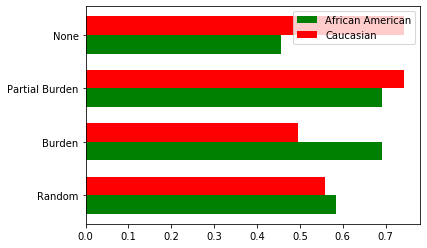

In [16]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

p_bf_aa_dp = p_bf_aa_m.datadf['pred'].round().mean()
p_bf_c_dp  = p_bf_c_m.datadf['pred'].round().mean()


print("random demo parity")
print(rf_c_dp)
print(rf_aa_dp)
print()

print("burden demo parity")
print(bf_c_dp)
print(bf_aa_dp)
print()

print("partial burden demo parity")
print(p_bf_c_dp)
print(p_bf_aa_dp)
print()

print("none demo parity")
print(c_dp)
print(aa_dp)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_dp,
         bf_aa_dp,
         p_bf_aa_dp,
         aa_dp]
c_dps  = [rf_c_dp,
         bf_c_dp,
         p_bf_c_dp,
         c_dp]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### equ. odds and opp

Pr{^Y= 1|A= 0,Y= 1}= Pr{^Y= 1|A= 1,Y= 1} is opp

random eq opp
0.82733816
0.8433735

burden eq opp
0.58309036
0.85625964

partial burden eq opp
0.9008746
0.85625964

default eq opp
0.9008746
0.7465224



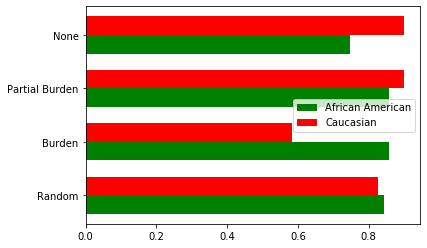

In [17]:
rf_aa_eqop = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eqop  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()

bf_aa_eqop = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eqop  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

p_bf_aa_eqop = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eqop  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

aa_eqop = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eqop  = c_m.datadf.query("Low == 1")['pred'].round().mean()

print("random eq opp")
print(rf_c_eqop)
print(rf_aa_eqop)
print()

print("burden eq opp")
print(bf_c_eqop)
print(bf_aa_eqop)
print()

print("partial burden eq opp")
print(p_bf_c_eqop)
print(p_bf_aa_eqop)
print()

print("default eq opp")
print(c_eqop)
print(aa_eqop)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_eqop,
         bf_aa_eqop,
         p_bf_aa_eqop,
         aa_eqop]
c_dps  = [rf_c_eqop,
         bf_c_eqop,
         p_bf_c_eqop,
         c_eqop]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

random eq odds
given y = 0
0.22072072
0.32804233
delta:  -0.107321605
given y = 1
0.82733816
0.8433735
delta:  -0.016035318

burden eq odds
given y = 0
0.30254778
0.56658876
delta:  -0.26404098
given y = 1
0.58309036
0.85625964
delta:  -0.27316928

partial burden eq odds
given y = 0
0.40127388
0.56658876
delta:  -0.16531488
given y = 1
0.9008746
0.85625964
delta:  0.04461497

default eq odds
given y = 0
0.40127388
0.23481308
delta:  0.1664608
given y = 1
0.9008746
0.7465224
delta:  0.15435219



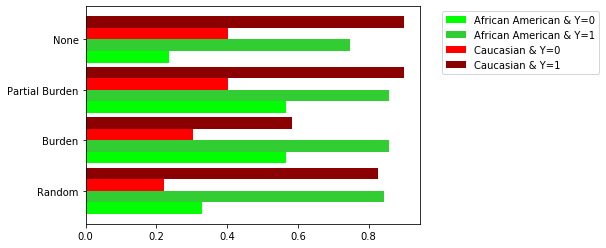

In [18]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps_0 = [rf_aa_eq0,
         bf_aa_eq0,
         p_bf_aa_eq0,
         aa_eq0]
c_dps_0  = [rf_c_eq0,
         bf_c_eq0,
         p_bf_c_eq0,
         c_eq0]
aa_dps_1 = [rf_aa_eq1,
         bf_aa_eq1,
         p_bf_aa_eq1,
         aa_eq1]
c_dps_1  = [rf_c_eq1,
         bf_c_eq1,
         p_bf_c_eq1,
         c_eq1]

ind = np.arange(4)
width = .23
ax.barh(ind, aa_dps_0, width, color='lime', label='African American & Y=0')
ax.barh(ind+width, aa_dps_1, width, color='limegreen', label='African American & Y=1')
ax.barh(ind+(width*2), c_dps_0, width, color='red', label='Caucasian & Y=0')
ax.barh(ind+(width*3), c_dps_1, width, color='darkred', label='Caucasian & Y=1')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_yticks((ind + (width*3/2)))
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))

plt.show()

In [19]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.22072072
0.32804233
delta:  -0.107321605
given y = 1
0.82733816
0.8433735
delta:  -0.016035318

burden eq odds
given y = 0
0.30254778
0.56658876
delta:  -0.26404098
given y = 1
0.58309036
0.85625964
delta:  -0.27316928

partial burden eq odds
given y = 0
0.40127388
0.56658876
delta:  -0.16531488
given y = 1
0.9008746
0.85625964
delta:  0.04461497

default eq odds
given y = 0
0.40127388
0.23481308
delta:  0.1664608
given y = 1
0.9008746
0.7465224
delta:  0.15435219



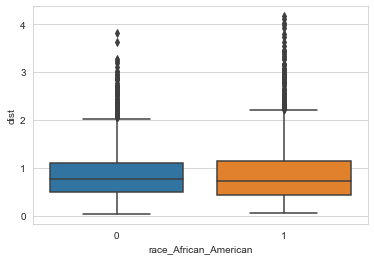

In [26]:
import seaborn as sns

sns.set_style("whitegrid")
ax = sns.boxplot(x="race_African_American", y="dist", data=burden_data)
plt.show()

(3175, 9)
(2103, 9)


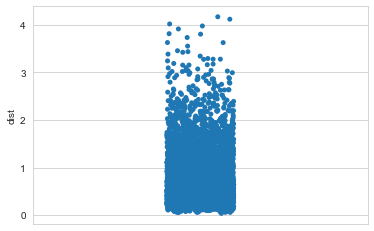

In [40]:

print(burden_data[burden_data['race_African_American'] == 1].shape)
print(burden_data[burden_data['race_African_American'] == 0].shape)

tips = sns.load_dataset("tips")
sns.stripplot(data=burden_data, y="dist", hue='race_African_American')
plt.show()